<a href="https://colab.research.google.com/github/benmsanderson/energybalance/blob/main/4xco2_bayesian_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do: collect models of same type?

In [ ]:
do_mcmc=0
do_pct=0
do_mcmcr=0
do_pctr=0
authdrive=1
nsteps=3000
nburn=2000

# Setup


In [ ]:
def find(lst, a):
    return [i for i, x in enumerate(lst) if x==a]

## Install some stuff

In [ ]:
!pip install --upgrade xarray zarr gcsfs cftime matplotlib==3.1.3 progress eofs netcdf4 >/dev/null
#!pip install https://github.com/matplotlib/basemap/archive/master.zip >/dev/null
!pip install lmfit corner emcee >/dev/null
!pip install nc-time-axis
!pip install xlrd==1.2.0



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 2.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


Import stuff

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
from cycler import cycler
import nc_time_axis
from netCDF4 import num2date
import numpy as np
#import pydsm.relab as relab
import numpy.matlib
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import pickle
import cftime
#import cartopy.crs as ccrs
import dask as da
from eofs.xarray import Eof
from sys import getsizeof
from IPython.display import HTML, display
import time
import scipy
import lmfit
#import seaborn as sns
import emcee
import corner
from scipy import linalg
#from mpl_toolkits.basemap import Basemap
import requests




xr.set_options(display_style='html')

#code for pretty progress bars
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


Activate Google Drive to store arrays

In [ ]:
if authdrive:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

## Open xarray datasets

In [ ]:
#CMIP6
dslr_4x = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_4x_v2.nc")
dslr_cnt = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/dsall_cnt_v2.nc")
dslr_hist = xr.open_dataset("/content/drive/MyDrive/colab_4xco2/historical_gm.nc")


Define model names

In [ ]:
mdlslr=dslr_cnt.ens.model
family=dslr_cnt.ens.family
gens=['LongRunMIP','CMIP5','CMIP6']
nmlr=len(mdlslr)


Indexes of ensemble names

In [ ]:
findex0=[]
for j, gen in enumerate(gens):
  findex0.append([i for i, s in enumerate(family) if gen in s])


## Get RCP85 forcing


In [ ]:

url='http://www.pik-potsdam.de/~mmalte/rcps/data/RCP85_MIDYEAR_RADFORCING.xls'
r = requests.get(url)
open('temp.xls', 'wb').write(r.content)
df85 = pd.read_excel('temp.xls',sheet_name='RCP85_MIDYEAR_RADFORCING',skiprows=59,index_col=0)

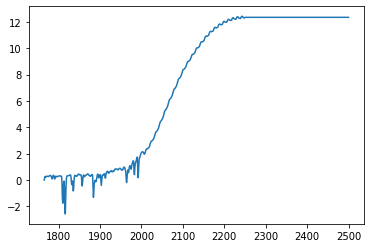

In [ ]:

f85=df85['TOTAL_INCLVOLCANIC_RF']
plt.plot(f85)

In [ ]:
f85.index[240]

2005

## Define functions

In [ ]:
def f_a4x(x):
  fcg=np.ones(len(x))
  return fcg

In [ ]:
def f_tc4(x):
  ln=len(x)-140
  if ln<0:
     ln=0
  fcg=np.hstack((np.arange(0,140)/140,np.ones([ln])))
  return fcg

In [ ]:
def f_tc2(x):
  ln=len(x)-70
  if ln<0:
     ln=0
  fcg=np.hstack((np.arange(0,70)/140,np.ones([ln])/2))
  return fcg

In [ ]:
def f_85(x):
  lng=np.min((len(x),len(f85)))
  fcg=np.zeros(len(x))
  fcg[:lng]=f85[:lng]
  fcg[lng:]=f85.iloc[-1]
  fcg=fcg/7.2
  return fcg

In [ ]:
def linear(x, m, b):
    return m*x + b

In [ ]:
def cmdl(x, prms):
   nmodes=int(len(prms)/2)
   tout=x*0
   for i in np.arange(0,nmodes):
     si=prms[i]
     ti=prms[i+nmodes]
     tout=tout+si*(1-np.exp(-x/ti))
   return tout

In [ ]:
def rmdl(x, prms):
   nmodes=int(len(prms)/2)
   rout=x*0
   for i in np.arange(0,nmodes):
     si=prms[i]
     ti=prms[i+nmodes]
     rout=rout+si*(np.exp(-x/ti))
   rout=rout
   return rout

In [ ]:
def cnvmdl(fcg,ntrnc,lag,*args):
  x=np.arange(0,len(fcg)+lag)
  plse=cmdl(x,args)
  dfcg=np.diff(np.hstack((0,fcg,np.repeat(fcg[-1],lag))))
  dfcg=dfcg[:ntrnc]
  convout=scipy.signal.lfilter(dfcg,1,plse)
  lagout=convout[lag:]
  return lagout

In [ ]:
def cnvmdlr(fcg,ntrnc,lag,*args):
  x=np.arange(0,len(fcg)+lag)
  plse=rmdl(x,args)
  dfcg=np.diff(np.hstack((0,fcg,np.repeat(fcg[-1],lag))))
  dfcg=dfcg[:ntrnc]
  convout=scipy.signal.lfilter(dfcg,1,plse)+args[-1]
  lagout=convout[lag:]
  return lagout

In [ ]:
dlag=np.repeat(0,len(mdlslr))
dlag[find(mdlslr,'GFDLCM3')[0]]=70
dlag[find(mdlslr,'ECEARTH')[0]]=240


In [ ]:
flr=np.repeat(1,len(mdlslr))
flr[find(mdlslr,'ECEARTH')[0]]=500
flr[find(mdlslr,'GFDLCM3')[0]]=70
flr[find(mdlslr,'GFDLESM2M')[0]]=70
flr[find(mdlslr,'MIROC32')[0]]=140


In [ ]:
flt=np.repeat(f_a4x,len(mdlslr))
flt[find(mdlslr,'ECEARTH')[0]]=f_85
flt[find(mdlslr,'GFDLCM3')[0]]=f_tc2
flt[find(mdlslr,'GFDLESM2M')[0]]=f_tc2
flt[find(mdlslr,'MIROC32')[0]]=f_tc4

In [ ]:
fscn=np.repeat('ABRUPT4X',len(mdlslr))
fscn[find(mdlslr,'ECEARTH')[0]]='RCP85'
fscn[find(mdlslr,'GFDLCM3')[0]]='1pct2x'
fscn[find(mdlslr,'GFDLESM2M')[0]]='1pct2x'
fscn[find(mdlslr,'MIROC32')[0]]='1pct4x'

In [ ]:
scl=np.repeat(1.0,len(mdlslr))
scl[find(mdlslr,'ECEARTH')[0]]=1/f_85(np.arange(1,1000))[-1]
scl[find(mdlslr,'GFDLCM3')[0]]=2
scl[find(mdlslr,'GFDLESM2M')[0]]=2

In [ ]:
1/f_85(np.arange(1,1000))[-1]

0.5836891472650151

In [ ]:
def expotas2(x, i, s1, s2, t1, t2):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,t1,t2])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,t1,t2)
  return out

In [ ]:
def expotas3(x, i, s1, s2, s3, t1, t2, t3):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,t1,t2,t3])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,t1,t2,t3)
  return out

In [ ]:
def expotas4(x, i, s1, s2, s3, s4, t1, t2, t3,t4):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,s4,t1,t2,t3,t4])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,t1,t2,t3,t4)
  return out

In [ ]:
def expotas5(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5):
  if flr[i]==1:
    out=cmdl(x,[s1,s2,s3,s4,s5,t1,t2,t3,t4,t5])
  else:
    out=cnvmdl(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,s5,t1,t2,t3,t4,t5)
  return out

In [ ]:
def exporad2(x, i, s1, s2, t1, t2,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,t1,t2])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,t1,t2,c)
  return out

In [ ]:
def exporad3(x, i, s1, s2, s3, t1, t2, t3,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,t1,t2,t3])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,t1,t2,t3,c)
  return out

In [ ]:
def exporad4(x, i, s1, s2, s3, s4, t1, t2, t3,t4,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,s4,t1,t2,t3,t4])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,t1,t2,t3,t4,c)
  return out

In [ ]:
def exporad5(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5,c):
  if flr[i]==1:
    out=rmdl(x,[s1,s2,s3,s4,s5,t1,t2,t3,t4,t5])+c
  else:
    out=cnvmdlr(flt[i](x),flr[i],dlag[i],s1,s2,s3,s4,s5,t1,t2,t3,t4,t5,c)
  return out

## Define timeseries


In [ ]:
net_cnt=dslr_cnt.rsut+dslr_cnt.rlut-dslr_cnt.rsdt
net_4x=dslr_4x.rsut+dslr_4x.rlut-dslr_4x.rsdt

net_cnt_100=np.empty([len(mdlslr),1])
len4x=np.empty([len(mdlslr),1])

for i,j in enumerate(mdlslr):
  tmp=net_cnt[i,net_cnt[i,:].notnull()]
  net_cnt_100[i]=tmp[-500:].mean()
  tmp4=net_4x[i,net_4x[i,:].notnull()]
  len4x[i]=len(tmp4)
netanomlr=dslr_4x.rsut.copy(deep=True)*0
netcntlr=net_cnt.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  netanomlr[i,:]=dslr_4x.rsut[i,:]+dslr_4x.rlut[i,:]-dslr_4x.rsdt[i,:]-net_cnt_100[i]
  netcntlr[i,:]=net_cnt[i,:]-net_cnt_100[i]
  

In [ ]:
ts_cnt_100=np.empty([len(mdlslr),1])

#TAS anomaly
for i,j in enumerate(mdlslr):
  tmp=dslr_cnt.tas[i,dslr_cnt.tas[i,:].notnull()]
  ts_cnt_100[i]=tmp[-500:].mean()
tsanomlr=dslr_4x.tas.copy(deep=True)*0
tscntlr=dslr_cnt.tas.copy(deep=True)*0

for i,j in enumerate(mdlslr):
  tsanomlr[i,:]=dslr_4x.tas[i,:]-ts_cnt_100[i]
  tscntlr[i,:]=dslr_cnt.tas[i,:]-ts_cnt_100[i]


In [ ]:
#redo gfdlcm3
#i=find(mdlslr,'GFDLCM3')[0]
#tmp=dslr_cnt.tas[i,dslr_cnt.tas[i,:].notnull()]
#ts_cnt_100[i]=tmp[:500].mean()
#tsanomlr[i,:]=dslr_4x.tas[i,:]-ts_cnt_100[i]
#tscntlr[i,:]=dslr_cnt.tas[i,:]-ts_cnt_100[i]

In [ ]:
len(np.where(~np.isnan(tsanomlr[-1,:]))[0])
lents=[]
findex=[None] * 3
for j,phs in enumerate(findex0):
  findex[j]=[]
  for i,ii in enumerate(phs):
    lents.append(len(np.where(~np.isnan(tsanomlr[ii,:]))[0]))
    if lents[ii]>100:
      findex[j].append(ii)

In [ ]:
findex[0].remove(find(mdlslr,'CCSM3II')[0])

#Fit timescales


Exclude one of the CCSM3 pair

In [ ]:
rpts=np.hstack((findex[0],findex[1],findex[2]))
#rpts=[findex0[0][7]]
#rpts

In [ ]:
if 'result_lt2' not in globals():
  result_lt2=[None]*nmlr
if 'result_lr2' not in globals():
  result_lr2=[None]*nmlr
if 'result_lt3' not in globals():
  result_lt3=[None]*nmlr
if 'result_lr3' not in globals():
  result_lr3=[None]*nmlr
if 'result_lt4' not in globals():
  result_lt4=[None]*nmlr
if 'result_lr4' not in globals():
  result_lr4=[None]*nmlr
if 'result_lt5' not in globals():
  result_lt5=[None]*nmlr
if 'result_lr5' not in globals():
  result_lr5=[None]*nmlr

if 'etc_pct2' not in globals():
  etc_pct2=np.zeros((len(mdlslr),3,10000))
  eti_pct2=np.zeros((len(mdlslr),3,10000))
if 'etc_pct3' not in globals():
  etc_pct3=np.zeros((len(mdlslr),3,10000))
  eti_pct3=np.zeros((len(mdlslr),3,10000))
if 'etc_pct4' not in globals():
  etc_pct4=np.zeros((len(mdlslr),3,10000))
  eti_pct4=np.zeros((len(mdlslr),3,10000))
if 'etc_pct5' not in globals():
  etc_pct5=np.zeros((len(mdlslr),3,10000))
  eti_pct5=np.zeros((len(mdlslr),3,10000))

if 'ti_pct2' not in globals():
  t_pct2=np.zeros((len(mdlslr),3,10000))
  ti_pct2=np.zeros((len(mdlslr),3,10000))
if 'ti_pct3' not in globals():
  t_pct3=np.zeros((len(mdlslr),3,10000))
  ti_pct3=np.zeros((len(mdlslr),3,10000))
if 'ti_pct4' not in globals():
  t_pct4=np.zeros((len(mdlslr),3,10000))
  ti_pct4=np.zeros((len(mdlslr),3,10000))
if 'ti_pct5' not in globals():
  t_pct5=np.zeros((len(mdlslr),3,10000))
  ti_pct5=np.zeros((len(mdlslr),3,10000))

## Fit timeseries (2 timescales)

In [ ]:
model = lmfit.Model(expotas2)
exp_tparamslr=np.zeros((nmlr,7))



#result_lt2=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    pt = model.make_params(s1=10.,s2=10,t1=1.,t2=50.)
    pt.add_many(('i',     i,  False, None, None, None),
                ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps/3, burn=nburn/3, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt2[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt2.pickle", "wb")
  pickle.dump(result_lt2, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt2.pickle", "rb")
  result_lt2= pickle.load(file_pkl)
  file_pkl.close()

if do_pct:
  #etc_pct2=np.zeros((len(mdlslr),3,10000))
  #eti_pct2=np.zeros((len(mdlslr),3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lt2[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    etc_pct2[i,:,:]=np.percentile(tdist,[5,50,95],1)
    eti_pct2[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc2.pickle", "wb")
  pickle.dump([etc_pct2,eti_pct2], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc2.pickle", "rb")
  etc_pct2,eti_pct2= pickle.load(file_pkl)
  file_pkl.close()

In [ ]:
model = lmfit.Model(exporad2)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr2=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p = model.make_params(i=i, s1=10.,s2=10.,t1=1.,t2=50.,c=0.)
    p.add_many(('i',     i,  False, None, None, None),
                ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps/2, burn=nburn/2, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr2[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr2.pickle", "wb")
  pickle.dump(result_lr2, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr2.pickle", "rb")
  result_lr2= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct2=np.zeros((nmlr,3,10000))
  #ti_pct2=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr2[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],t1=ptmp[2],t2=ptmp[3],c=ptmp[4])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    t_pct2[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct2[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct2.pickle", "wb")
  pickle.dump([t_pct2,ti_pct2], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct2.pickle", "rb")
  t_pct2,ti_pct2= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (4 timescales)


In [ ]:
model = lmfit.Model(expotas4)
exp_tparamslr=np.zeros((nmlr,7))


#result_lt4=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    pt = model.make_params(i=i,s1=10.,s2=10,s3=10.,s4=10,t1=1.,t2=50.,t3=200.,t4=2000.)
    pt.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   200,  True, 100, 1000,  None),
           ('t4',   1000,  True,  1000,  5000,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt4[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt4.pickle", "wb")
  pickle.dump(result_lt4, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt4.pickle", "rb")
  result_lt4= pickle.load(file_pkl)
  file_pkl.close()



if do_pct:
  #etc_pct4=np.zeros((len(mdlslr),3,10000))
  #eti_pct4=np.zeros((len(mdlslr),3,10000))

  for row,i  in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    print(i)
    result_emcee=result_lt4[i]
    tdist4=np.zeros((10000,len(result_emcee.flatchain)))
    tidist4=np.zeros((10000,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tdist4[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tidist4[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    etc_pct4[i,:,:]=np.percentile(tdist4,[5,50,95],1)
    eti_pct4[i,:,:]=np.percentile(tidist4,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc4.pickle", "wb")
  pickle.dump([etc_pct4,eti_pct4], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc4.pickle", "rb")
  etc_pct4,eti_pct4= pickle.load(file_pkl)
  file_pkl.close()

In [ ]:
model = lmfit.Model(exporad4)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr4=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    p = model.make_params(i=i,s1=10.,s2=10.,s3=10.,s4=10.,t1=1.,t2=50.,t3=500.,t4=2000.,c=0.)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   500,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr4[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr4.pickle", "wb")
  pickle.dump(result_lr4, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr4.pickle", "rb")
  result_lr4= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct4=np.zeros((nmlr,3,10000))
  #ti_pct4=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr4[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))

    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],t1=ptmp[4],t2=ptmp[5],t3=ptmp[6],t4=ptmp[7],c=ptmp[8])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct4[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct4[i,:,:]=np.percentile(tidist,[5,50,95],1)
    
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct4.pickle", "wb")
  pickle.dump([t_pct4,ti_pct4], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct4.pickle", "rb")
  t_pct4,ti_pct4= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (5 timescales)

In [ ]:
model = lmfit.Model(expotas5)
exp_tparamslr=np.zeros((nmlr,7))


#result_lt5=[None]*nmlr
 
if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):

    print(i)
    pt = model.make_params(i=1,s1=10.,s2=10,s3=10.,s4=10,s5=10,t1=1.,t2=50.,t3=200.,t4=2000.,t5=8000)
    pt.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('s5',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   200,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('t5',   7000  ,  True,  5000,  10000,  None))
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps*2, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt5[i]=result_emcee
    out.update(progress(i+1, len(findex[0])))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt5.pickle", "wb")
  pickle.dump(result_lt5, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt5.pickle", "rb")
  result_lt5= pickle.load(file_pkl)
  file_pkl.close()



if do_pct:
  #etc_pct5=np.zeros((len(mdlslr),3,10000))
  #eti_pct5=np.zeros((len(mdlslr),3,10000))

  for row,i in enumerate(rpts):
  #row=findex[0][-1]
  #for i in range(5,6):
    print(i)
    result_emcee=result_lt5[i]
    tdist5=np.zeros((10000,len(result_emcee.flatchain)))
    tidist5=np.zeros((10000,len(result_emcee.flatchain)))
   
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tdist5[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tidist5[:,j]=model.eval(params=p1, x=np.arange(1,10001))      
    etc_pct5[i,:,:]=np.percentile(tdist5,[5,50,95],1)
    eti_pct5[i,:,:]=np.percentile(tidist5,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc5.pickle", "wb")
  pickle.dump([etc_pct5,eti_pct5], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pc5.pickle", "rb")
  etc_pct5,eti_pct5= pickle.load(file_pkl)
  file_pkl.close()

In [ ]:
model = lmfit.Model(exporad5)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr5=[None]*nmlr

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
#  for i, row in enumerate(findex[0]):
    p = model.make_params(i=i,s1=10.,s2=10.,s3=10.,s4=10.,s5=10.,t1=1.,t2=50.,t3=500.,t4=2000.,t5=5000.,c=0.)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    p.add_many(('i',     i,  False, None, None, None),
           ('s1',    5,  True, 0, 10,  None),
           ('s2',   5,  True,  0.,  10,  None),
           ('s3',    5,  True, 0, 10,  None),
           ('s4',   0,  True,  0.,  10,  None),
           ('s5',   0,  True,  0.,  10,  None),
           ('t1',   1,  True, 0, 10,  None),
           ('t2',   50,  True,  10,  100,  None),
           ('t3',   500,  True, 100, 1000,  None),
           ('t4',   2000,  True,  1000,  5000,  None),
           ('t5',   7000,  True,  5000,  10000,  None),
           ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=p, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps*2, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr5[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr5.pickle", "wb")
  pickle.dump(result_lr5, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr5.pickle", "rb")
  result_lr5= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  #t_pct5=np.zeros((nmlr,3,10000))
  #ti_pct5=np.zeros((nmlr,3,10000))

  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr5[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],s4=ptmp[3],s5=ptmp[4],t1=ptmp[5],t2=ptmp[6],t3=ptmp[7],t4=ptmp[8],t5=ptmp[9],c=ptmp[10])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct5[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct5[i,:,:]=np.percentile(tidist,[5,50,95],1)
    
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct5.pickle", "wb")
  pickle.dump([t_pct5,ti_pct5], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct5.pickle", "rb")
  t_pct5,ti_pct5= pickle.load(file_pkl)
  file_pkl.close()

## Fit timeseries (3 timescales)



Temperature

In [ ]:
model = lmfit.Model(expotas3)
exp_tparamslr=np.zeros((nmlr,7))

#result_lt3=[None]*len(mdlslr)
et_pct=np.zeros((len(mdlslr),3,10000))
etcr_pct=np.zeros((len(mdlslr),3))
et140_pct=np.zeros((len(mdlslr),3))
etcr35_pct=np.zeros((len(mdlslr),3))
pfit=np.zeros((len(mdlslr),3,7))

if do_mcmc:
  out = display(progress(0, 1), display_id=True)
  #for i, row in enumerate(mdlslr):
  for j,i in enumerate(rpts):
    print(i)
    y_array=tsanomlr[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    x_array=np.arange(1,len(y_array)+1)
    pt = model.make_params(s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.)
    pt.add_many(('i',     i,  False, None, None, None),
               ('s1',    5,  True, 0, 10,  None),
               ('s2',   5,  True,  0.,  10,  None),
               ('s3',   5,  True,  0., 10,  None),
               ('t1',   1,  True, 0, 10,  None),
               ('t2',   50,  True,  10,  100,  None),
               ('t3',  500, True, 100, 1000, None))
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lt3[i]=result_emcee
    out.update(progress(i+1, nmlr))

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt3.pickle", "wb")
  pickle.dump(result_lt3, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lt3.pickle", "rb")
  result_lt3= pickle.load(file_pkl)
  file_pkl.close()
if do_pct:
  #etc_pct3=np.zeros((len(mdlslr),3,10000))
  #eti_pct3=np.zeros((len(mdlslr),3,10000))

  for row, i in enumerate(rpts):
    print(i)
    result_emcee=result_lt3[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    pdist=np.zeros((7,len(result_emcee.flatchain)))
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      pdist[:,j]=ptmp
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p_i = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tidist[:,j]=model.eval(params=p_i, x=np.arange(1,10001))
    pfit[i,:,:]=np.percentile(pdist,[5,50,95],1)
    etc_pct3[i,:,:]=np.percentile(tdist,[5,50,95],1)
    eti_pct3[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct3.pickle", "wb")
  pickle.dump([etc_pct3,eti_pct3], file_pkl)
  file_pkl.close()
# Getting back the objects:
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/etc_pct3.pickle", "rb")
  etc_pct3,eti_pct3 = pickle.load(file_pkl)
  file_pkl.close()

4xco2

In [ ]:
model = lmfit.Model(exporad3)

exp_fparamslr=np.zeros((nmlr,7))


#result_lr3=[None]*nmlr
#t_pct3=np.zeros((nmlr,3,10000))
#ti_pct3=np.zeros((nmlr,3,10000))

if do_mcmcr:
  out = display(progress(0, 1), display_id=True)
  for row,i in enumerate(rpts):
    pt = model.make_params(i=i,s1=10.,s2=10.,s3=10.,t1=1.,t2=50.,t3=1000.,c=0)
    y_array=-net_4x[i,:]
    y_array = y_array[~numpy.isnan(y_array)]
    pt.add_many(('i',     i,  False, None, None, None),
               ('s1',    5,  True, 0, 10,  None),
               ('s2',   5,  True,  0.,  10,  None),
               ('s3',   5,  True,  0., 10,  None),
               ('t1',   1,  True, 0, 10,  None),
               ('t2',   50,  True,  10,  100,  None),
               ('t3',  500, True, 100, 1000, None),
               ('c',  y_array.values[-1], True, -5, 5,None))

    x_array=np.arange(1,len(y_array)+1)
    result = model.fit(y_array.values, params=pt, x=x_array, method='Nelder', nan_policy='omit')
    emcee_kws = dict(steps=nsteps, burn=nburn, thin=20, is_weighted=False,
                  progress=False)
    emcee_params = result.params.copy()
    result_emcee=model.fit(data=y_array, x=x_array, params=emcee_params, method='emcee',
                          nan_policy='omit', fit_kws=emcee_kws,verbose=False)
    result_lr3[i]=result_emcee
    out.update(progress(i+1, nmlr))
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr3.pickle", "wb")
  pickle.dump(result_lr3, file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/res_lr3.pickle", "rb")
  result_lr3= pickle.load(file_pkl)
  file_pkl.close()

if do_pctr:
  for row,i in enumerate(rpts):
    print(i)
    result_emcee=result_lr3[i]
    tdist=np.zeros((10000,len(result_emcee.flatchain)))
    tidist=np.zeros((10000,len(result_emcee.flatchain)))
    
    for j in range(0,len(result_emcee.flatchain)):
      ptmp=result_emcee.flatchain.loc[j].to_numpy()
      p1 = model.make_params(i=0,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tdist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
      p1 = model.make_params(i=i,s1=ptmp[0],s2=ptmp[1],s3=ptmp[2],t1=ptmp[3],t2=ptmp[4],t3=ptmp[5],c=ptmp[6])
      tidist[:,j]=model.eval(params=p1, x=np.arange(1,10001))
    t_pct3[i,:,:]=np.percentile(tdist,[5,50,95],1)
    ti_pct3[i,:,:]=np.percentile(tidist,[5,50,95],1)

  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct3.pickle", "wb")
  pickle.dump([t_pct3,ti_pct3], file_pkl)
  file_pkl.close()
else:
  file_pkl = open("/content/drive/MyDrive/colab_4xco2/t_pct3.pickle", "rb")
  t_pct3,ti_pct3= pickle.load(file_pkl)
  file_pkl.close()

#assess timescales

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


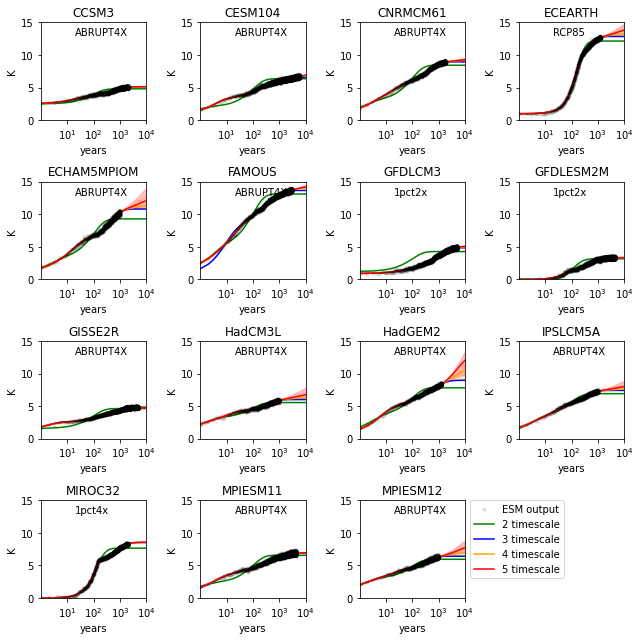

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)

for j, i in enumerate(findex[0]):
   print(j)
   p2=axes[j].plot(eti_pct2[i,1,:],'g')
   axes[j].fill_between(np.arange(0,10000),eti_pct2[i,0,:],eti_pct2[i,2,:],color=[0.6,1,0.6],alpha=0.1)
   p3=axes[j].plot(eti_pct3[i,1,:],'b')
   axes[j].fill_between(np.arange(0,10000),eti_pct3[i,0,:],eti_pct3[i,2,:],color=[0.6,.6,0.1],alpha=0.1)

   p4=axes[j].plot(eti_pct4[i,1,:],'orange')
   axes[j].fill_between(np.arange(0,10000),eti_pct4[i,0,:],eti_pct4[i,2,:],color=[1,.8,.5],alpha=0.5)

   p5=axes[j].plot(eti_pct5[i,1,:],'r')
   axes[j].fill_between(np.arange(0,10000),eti_pct5[i,0,:],eti_pct5[i,2,:],color=[1,.5,.5],alpha=0.5)

   p1=axes[j].plot(tsanomlr[i,:],'k.',alpha=0.1)
   axes[j].set_xscale('log')
   axes[j].set_title(mdlslr[i])
   axes[j].set_ylabel('K')
   axes[j].set_xlabel('years')
   axes[j].text(20,13,fscn[i])
   axes[j].set_ylim([0,15])
   axes[j].set_xlim([1,10000])
   axes[j].set_xticks([10,100,1000,10000])


   

fig.delaxes(axes[15])

plt.tight_layout()


axes[j].legend([p1[0],p2[0],p3[0],p4[0],p5[0]],['ESM output','2 timescale','3 timescale','4 timescale','5 timescale'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_t.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_t.pdf", bbox_inches='tight')


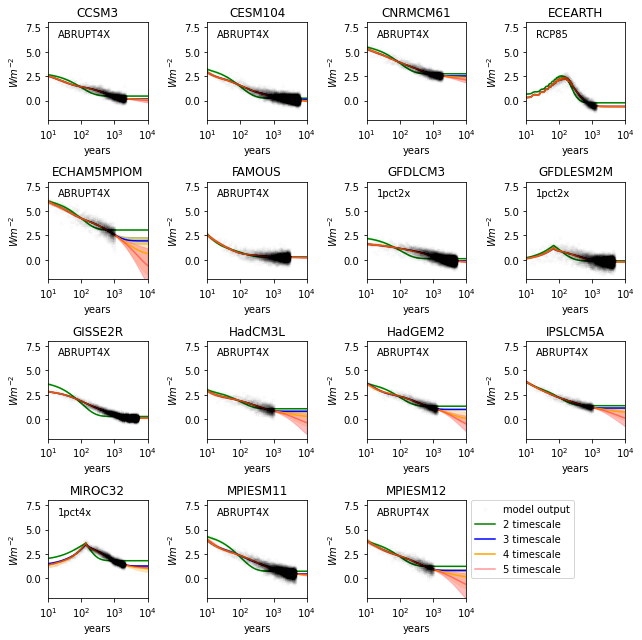

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['2','3','4','5']
fig.set_figheight(9)
fig.set_figwidth(9)

for j, i in enumerate(findex[0]):
   p2=axes[j].plot(ti_pct2[i,1,:],'g')
   axes[j].fill_between(np.arange(0,10000),ti_pct2[i,0,:],ti_pct2[i,2,:],color=[0.6,1,0.6],alpha=0.5)
   p3=axes[j].plot(ti_pct3[i,1,:],'b')
   axes[j].fill_between(np.arange(0,10000),ti_pct3[i,0,:],ti_pct3[i,2,:],color=[0.6,.6,0.1],alpha=0.5)

   p4=axes[j].plot(ti_pct4[i,1,:],'orange')
   axes[j].fill_between(np.arange(0,10000),ti_pct4[i,0,:],ti_pct4[i,2,:],color=[1,.8,.5],alpha=0.5)

   p5=axes[j].plot(ti_pct5[i,1,:],'r',alpha=0.4)
   axes[j].fill_between(np.arange(0,10000),ti_pct5[i,0,:],ti_pct5[i,2,:],color=[1,.5,.5],alpha=0.5)

   p1=axes[j].plot(-net_4x[i,:],'k.',alpha=0.01)
   axes[j].set_xscale('log')
   axes[j].set_xlim([10,10000])
   axes[j].set_ylim([-2,8])

   axes[j].set_ylabel('$Wm^{-2}$')
   axes[j].set_xlabel('years')
   axes[j].text(20,6.5,fscn[i])
   axes[j].set_xticks([10,100,1000,10000])


   axes[j].set_title(mdlslr[i])

fig.delaxes(axes[15])

plt.tight_layout()
axes[j].legend([p1[0],p2[0],p3[0],p4[0],p5[0]],['model output','2 timescale','3 timescale','4 timescale','5 timescale'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_r.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/tmscl_r.pdf", bbox_inches='tight')

In [ ]:
errts=np.zeros([4,len(mdlslr)])
for i, row in enumerate(findex[0]):
  errts[0,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct2[row,1,:len(tsanomlr[row,:])]))
  errts[1,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct3[row,1,:len(tsanomlr[row,:])]))
  errts[2,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct4[row,1,:len(tsanomlr[row,:])]))
  errts[3,row]=np.mean(np.square(tsanomlr[row,:]-eti_pct5[row,1,:len(tsanomlr[row,:])]))
  



In [ ]:
errrs=np.zeros([4,len(mdlslr)])
for i, row in enumerate(findex[0]):
  errrs[0,row]=np.mean(np.square(net_4x[row,:]+ti_pct2[row,1,:len(tsanomlr[row,:])]))
  errrs[1,row]=np.mean(np.square(net_4x[row,:]+ti_pct3[row,1,:len(tsanomlr[row,:])]))
  errrs[2,row]=np.mean(np.square(net_4x[row,:]+ti_pct4[row,1,:len(tsanomlr[row,:])]))
  errrs[3,row]=np.mean(np.square(net_4x[row,:]+ti_pct5[row,1,:len(tsanomlr[row,:])]))
  


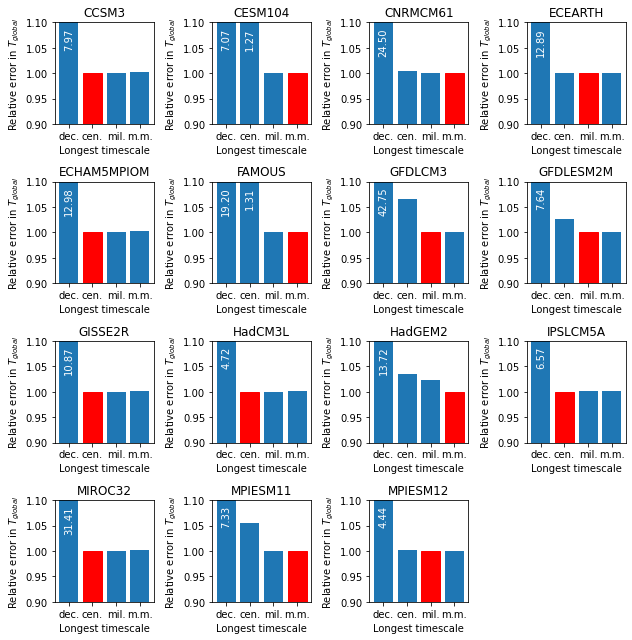

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['dec.','cen.','mil.','m.m.']
fig.set_figheight(9)
fig.set_figwidth(9)
bstmod=[None]*nmlr
for j, i in enumerate(findex[0]):
   
   barlist=axes[j].bar(x=timscl,height=errts[:,i]/np.min(errts[:,i]))
   bstmod[i]=np.argmin(errts[:,i],axis=0)
   barlist[bstmod[i]].set_color('r')
   axes[j].set_title(mdlslr[i])
  # axes[j].set_yscale('log')
   axes[j].set_ylim([.9,1.1])
   axes[j].set_ylabel('Relative error in $T_{global}$')
   axes[j].set_xlabel('Longest timescale')
   axes[j].text(0,1.09,f'{errts[0,i]/np.min(errts[:,i]):2.2f}',color='w',rotation=90,va='top',ha='center')
   if errts[1,i]/np.min(errts[:,i])>1.1:
     axes[j].text(1,1.09,f'{errts[1,i]/np.min(errts[:,i]):2.2f}',color='w',rotation=90,va='top',ha='center')
   

plt.tight_layout()
fig.delaxes(axes[15])

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/errtm_t.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/errtm_t.pdf", bbox_inches='tight')

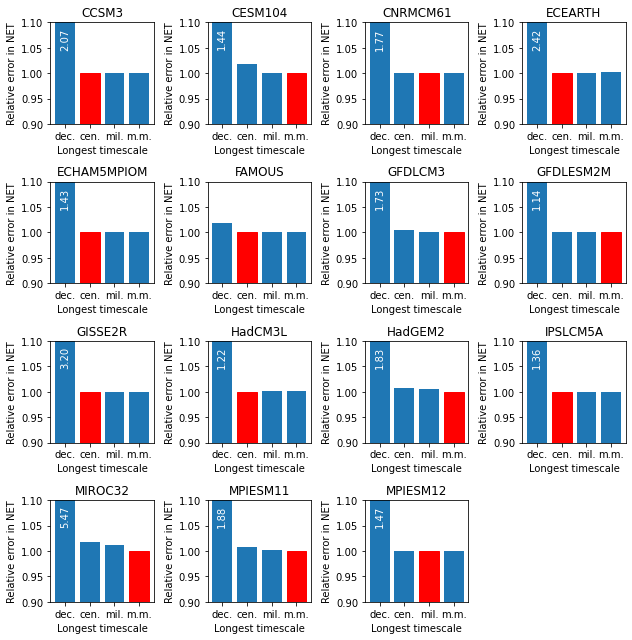

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

timscl=['dec.','cen.','mil.','m.m.']
fig.set_figheight(9)
fig.set_figwidth(9)
bstmod=[1]*nmlr
for j, i in enumerate(findex[0]):
   
   barlist=axes[j].bar(x=timscl,height=errrs[:,i]/np.min(errrs[:,i]))
   bstmod[i]=np.argmin(errrs[:,i],axis=0)
   barlist[bstmod[i]].set_color('r')
   axes[j].set_title(mdlslr[i])
  # axes[j].set_yscale('log')
   axes[j].set_ylim([.9,1.1])
   axes[j].set_ylabel('Relative error in NET')
   axes[j].set_xlabel('Longest timescale')
   axes[j].text(0,1.09,f'{errrs[0,i]/np.min(errrs[:,i]):2.2f}',color='w',rotation=90,va='top',ha='center')
   if errrs[1,i]/np.min(errrs[:,i])>1.1:
     axes[j].text(1,1.09,f'{errrs[1,i]/np.min(errrs[:,i]):2.2f}',color='w',rotation=90,va='top',ha='center')
   


plt.tight_layout()
fig.delaxes(axes[15])

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/errtm_r.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/errtm_r.pdf", bbox_inches='tight')

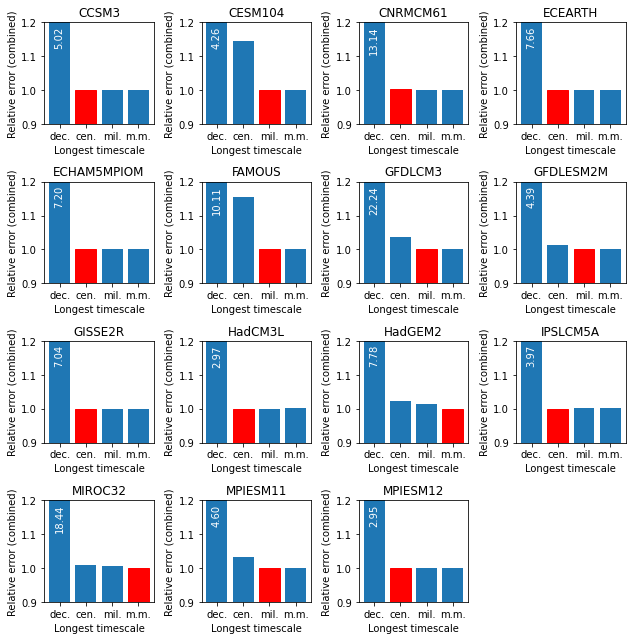

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()
timscl=['dec.','cen.','mil.','m.m.']
fig.set_figheight(9)
fig.set_figwidth(9)
bstmod=[1]*nmlr
for j, i in enumerate(findex[0]):
   e_combi=errrs[:,i]/np.min(errrs[:,i])/2+errts[:,i]/np.min(errts[:,i])/2
   barlist=axes[j].bar(x=timscl,height=e_combi)
   bstmod[i]=np.where(e_combi<1.005)[0][0]#np.argmin(e_combi,axis=0)
   barlist[bstmod[i]].set_color('r')
   axes[j].set_title(mdlslr[i])
  # axes[j].set_yscale('log')
   axes[j].set_ylim([.9,1.2])
   axes[j].set_ylabel('Relative error (combined)')
   axes[j].set_xlabel('Longest timescale')
   axes[j].text(0,1.19,f'{e_combi[0]:2.2f}',color='w',rotation=90,va='top',ha='center')
   if e_combi[1]>1.2:
     axes[j].text(1,1.19,f'{e_combi[1]:2.2f}',color='w',rotation=90,va='top',ha='center')
   


plt.tight_layout()
fig.delaxes(axes[15])

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/ecombi.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/ecombi.pdf", bbox_inches='tight')

# Define climate sensitivities

In [ ]:
et_pct=etc_pct3
eti_pct=eti_pct3
t_pct=t_pct3
ti_pct=ti_pct3
for i,j in enumerate(bstmod):

  if j==1:
    et_pct[i,:,:]=etc_pct3[i,:,:]
    eti_pct[i,:,:]=eti_pct3[i,:,:]
    t_pct[i,:,:]=t_pct3[i,:,:]
    ti_pct[i,:,:]=ti_pct3[i,:,:]
   
  elif j==2:
    et_pct[i,:,:]=etc_pct4[i,:,:]
    eti_pct[i,:,:]=eti_pct4[i,:,:]
    t_pct[i,:,:]=t_pct4[i,:,:]
    ti_pct[i,:,:]=ti_pct4[i,:,:]

  elif j==3:
    et_pct[i,:,:]=etc_pct5[i,:,:]
    eti_pct[i,:,:]=eti_pct5[i,:,:]
    t_pct[i,:,:]=t_pct5[i,:,:]
    ti_pct[i,:,:]=ti_pct5[i,:,:]

  else: 
    et_pct[i,:,:]=etc_pct3[i,:,:]
    eti_pct[i,:,:]=eti_pct3[i,:,:]
    t_pct[i,:,:]=t_pct3[i,:,:]
    ti_pct[i,:,:]=ti_pct3[i,:,:]


In [ ]:
et_pct.shape

(75, 3, 10000)

In [ ]:
cbal_extrap=t_pct[:,1,-1]

In [ ]:
mdlslr[5]

'ECHAM5MPIOM'

In [ ]:
cbal_extrap[5]

1.9417709149413835

In [ ]:
net_cnt_100[5]

array([-1.83478272])

In [ ]:
gsenslr=np.zeros((nmlr,1))
gsensls=np.zeros((nmlr,1))

gsenslr_corr=np.zeros((nmlr,1))

gsenslg=np.zeros((nmlr,1))

gfcglr=np.zeros((nmlr,1))
gfcglg=np.zeros((nmlr,1))
gfcgls=np.zeros((nmlr,1))


gsenslr_end=np.zeros((nmlr,1))

tmax=np.zeros((nmlr,1))
t150=np.zeros((nmlr,1))

ttcr=np.zeros((nmlr,1))
t140=np.zeros((nmlr,1))
ngood=np.zeros((nmlr,1))

for i, row in enumerate(mdlslr):
  offst=cbal_extrap[i]+net_cnt_100[i]
  x_scl=et_pct[i,1,:6000]
  y_scl=t_pct[i,1,:6000]+net_cnt_100[i]
  x_array=tsanomlr[i,:].to_numpy()*scl[i]
  y_array=-netanomlr[i,:].to_numpy()*scl[i]

  use=np.where(~numpy.isnan(x_array))
  t150[i]=x_array[140]
  x_array = x_array[use]
  y_array = y_array[use]

  x_short = x_array[use[:150]]
  y_short = y_array[use[:150]]
  isgd=np.where(~np.isnan(y_short))
  ngood[i]=np.shape(isgd)[1]
  #calculate standard Gregory
  if np.shape(isgd)[1]>100:
    if fscn[i]=='ABRUPT4X':
        popt_linear, pcov_linear = scipy.optimize.curve_fit(linear, x_short[isgd], y_short[isgd], p0=[-1, 10])
    else:
        popt_linear, pcov_linear = scipy.optimize.curve_fit(linear, x_scl[:150], y_scl[:150], p0=[-1, 10])
    
  else:
    popt_linear=np.empty((2,1))
    popt_linear[:]=np.nan


  if -popt_linear[1]/popt_linear[0]>0:
    gsenslr[i]=-popt_linear[1]/popt_linear[0]
    gsenslr_corr[i]=-(popt_linear[1]-offst)/popt_linear[0]
    
    gfcglr[i]=popt_linear[1]
  else:
    gsenslr[i]=np.nan
    gfcglr[i]=np.nan


  #calculate LR Gregory (lat 15cpt warming)
  tmax[i]=np.nanmax(x_array)

  numts=np.min((x_array > tmax[i]*.85).nonzero()).astype(int)
  x_end=x_array[numts:use[0].shape[0]]
  y_end=y_array[numts:use[0].shape[0]]

  if len(y_array)>500:
    popt_long, pcov_long = scipy.optimize.curve_fit(linear, x_end, y_end, p0=[-1, 10])
  else:
    popt_long=np.empty((2,1))
    popt_long[:]=np.nan    

  if -popt_long[1]/popt_long[0]>0:
    gsenslg[i]=-popt_long[1]/popt_long[0]
    gfcglg[i]=popt_long[1]
  else:
    gsenslg[i]=np.nan
    gfcglg[i]=np.nan


#calculate LR method for synthetic 4xco2
  x_send=x_scl[numts:use[0].shape[0]]
  y_send=y_scl[numts:use[0].shape[0]]
  if ~np.isnan(x_send[-1]):
      popt_slong, pcov_slong = scipy.optimize.curve_fit(linear, x_send, y_send, p0=[-1, 10])
  else:
    popt_slong=np.empty((2,1))
    popt_slong[:]=np.nan

  if -popt_slong[1]/popt_slong[0]>0:
    gsensls[i]=-popt_slong[1]/popt_slong[0]
    gfcgls[i]=popt_slong[1]
  else:
    gsensls[i]=np.nan
    gfcgls[i]=np.nan

#calculate TCR
  ttmp=scipy.signal.lfilter(np.ones([150]).T/140,1,x_array)
  if len(y_array)>139:
    ttcr[i]=ttmp[69]
    t140[i]=ttmp[139]
  else:
    ttcr[i]=np.nan
    t140[i]=np.nan


gsenslr_corr[find(mdlslr,'HadGEM2')[0]]=np.nan


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
ngood

array([[3.132e+03],
       [2.120e+03],
       [5.900e+03],
       [1.850e+03],
       [1.271e+03],
       [1.001e+03],
       [3.000e+03],
       [5.000e+03],
       [4.500e+03],
       [5.001e+03],
       [1.000e+03],
       [1.299e+03],
       [1.000e+03],
       [2.002e+03],
       [4.459e+03],
       [1.000e+03],
       [1.500e+02],
       [1.510e+02],
       [1.040e+02],
       [1.500e+02],
       [1.500e+02],
       [5.000e+00],
       [6.000e+00],
       [1.500e+02],
       [1.500e+02],
       [3.000e+02],
       [3.000e+02],
       [1.510e+02],
       [1.510e+02],
       [5.000e+00],
       [5.000e+00],
       [1.400e+02],
       [1.600e+02],
       [1.500e+02],
       [6.000e+00],
       [1.500e+02],
       [1.500e+02],
       [1.500e+02],
       [6.000e+00],
       [1.500e+02],
       [1.500e+02],
       [1.500e+02],
       [1.510e+02],
       [1.510e+02],
       [1.500e+02],
       [4.000e+02],
       [1.500e+02],
       [1.500e+02],
       [1.650e+02],
       [1.500e+02],


In [ ]:
gsenslr

array([[ 6.22665222],
       [ 5.35235155],
       [ 6.73649065],
       [10.83130271],
       [ 6.87356306],
       [11.67672578],
       [14.2647056 ],
       [ 6.38898356],
       [ 4.69526996],
       [ 4.80032858],
       [ 6.56691013],
       [ 9.37362379],
       [ 8.6621189 ],
       [ 8.77248889],
       [ 6.84796491],
       [ 6.70124422],
       [ 7.7488667 ],
       [ 7.08007264],
       [ 7.95846348],
       [ 6.5171783 ],
       [ 8.29207024],
       [        nan],
       [        nan],
       [ 8.46931506],
       [ 7.88524516],
       [ 5.1377451 ],
       [ 5.3649671 ],
       [ 4.86419357],
       [ 4.71344668],
       [        nan],
       [        nan],
       [ 8.19349011],
       [ 5.25080229],
       [ 9.3044749 ],
       [        nan],
       [ 7.26122231],
       [ 6.89666074],
       [ 5.60364694],
       [        nan],
       [ 5.64652704],
       [ 4.07892264],
       [ 9.40820495],
       [ 6.26810333],
       [ 5.96114994],
       [ 4.59694783],
       [12

In [ ]:
 pmn=np.nan*np.zeros((11,len(mdlslr)))
 pmn_prc=np.nan*np.zeros((11,len(mdlslr),3))
 
 for i,indy in enumerate(mdlslr):
    if bstmod[i]==1:
      result_emcee=result_lt3[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((7,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        pmn[0:3,i]=np.mean(ptmp[0:3,:],1)
        pmn[5:8,i]=np.mean(ptmp[3:6,:],1)
        pmn_prc[0:3,i,:]=np.percentile(ptmp[0:3,:],[10,50,90],1).T
        pmn_prc[5:8,i,:]=np.percentile(ptmp[3:6,:],[10,50,90],1).T        
      else:
        pmn[:,i]=np.NaN     
        pmn_prc[:,i,:]=np.NaN     

    if bstmod[i]==2:
      result_emcee=result_lt4[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((9,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        pmn[0:4,i]=np.mean(ptmp[0:4,:],1)
        pmn[5:9,i]=np.mean(ptmp[4:8,:],1)   
        pmn_prc[0:4,i,:]=np.percentile(ptmp[0:4,:],[10,50,90],1).T
        pmn_prc[5:9,i,:]=np.percentile(ptmp[4:8,:],[10,50,90],1).T 
      else:
        pmn[:,i]=np.NaN   
        pmn_prc[:,i,:]=np.NaN     

    if bstmod[i]==3:
      result_emcee=result_lt5[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((11,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        pmn[0:5,i]=np.mean(ptmp[0:5,:],1)
        pmn[5:10,i]=np.mean(ptmp[5:10,:],1)   
        pmn_prc[0:5,i,:]=np.percentile(ptmp[0:5,:],[10,50,90],1).T
        pmn_prc[5:10,i,:]=np.percentile(ptmp[5:10,:],[10,50,90],1).T 
      else:
        pmn[:,i]=np.NaN
        pmn_prc[:,i,:]=np.NaN     


In [ ]:
 prmn=np.nan*np.zeros((11,len(mdlslr)))
 prmn_prc=np.nan*np.zeros((11,len(mdlslr),3))

 for i,indy in enumerate(mdlslr):
    if bstmod[i]==1:
      result_emcee=result_lr3[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((8,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        prmn[0:3,i]=np.mean(ptmp[0:3,:],1)
        prmn[5:8,i]=np.mean(ptmp[3:6,:],1)
        prmn[10,i]=np.mean(ptmp[6,:])
        prmn_prc[0:3,i,:]=np.percentile(ptmp[0:3,:],[10,50,90],1).T
        prmn_prc[5:8,i,:]=np.percentile(ptmp[3:6,:],[10,50,90],1).T    
        prmn_prc[10,i,:]=np.percentile(ptmp[6,:],[10,50,90],0)   
      else:
        prmn[:,i]=np.NaN   
        prmn_prc[:,i,:]=np.NaN     
   
    if bstmod[i]==2:
      result_emcee=result_lr4[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((10,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        prmn[0:4,i]=np.mean(ptmp[0:4,:],1)
        prmn[5:9,i]=np.mean(ptmp[4:8,:],1)   
        prmn[10,i]=np.mean(ptmp[8,:])
        prmn_prc[0:4,i,:]=np.percentile(ptmp[0:4,:],[10,50,90],1).T
        prmn_prc[5:9,i,:]=np.percentile(ptmp[4:8,:],[10,50,90],1).T    
        prmn_prc[10,i,:]=np.percentile(ptmp[8,:],[10,50,90],0)
      else:
        prmn[:,i]=np.NaN
        prmn_prc[:,i,:]=np.NaN     

    if bstmod[i]==3:
      result_emcee=result_lr5[i]
      if result_emcee is not None:
        ptmp=np.NaN*np.zeros((12,len(result_emcee.flatchain)))
        for j in range(0,len(result_emcee.flatchain)):
          ptmp[:,j]=result_emcee.flatchain.loc[j].to_numpy()
        prmn[0:5,i]=np.mean(ptmp[0:5,:],1)
        prmn[5:10,i]=np.mean(ptmp[5:10,:],1)   
        prmn[10,i]=np.mean(ptmp[10,:])
        prmn_prc[0:5,i,:]=np.percentile(ptmp[0:5,:],[10,50,90],1).T
        prmn_prc[5:10,i,:]=np.percentile(ptmp[5:10,:],[10,50,90],1).T    
        prmn_prc[10,i,:]=np.percentile(ptmp[10,:],[10,50,90],0)
      else:
        prmn[:,i]=np.NaN
        prmn_prc[:,i,:]=np.NaN     


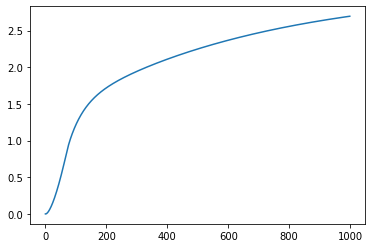

In [ ]:

i=7
plt.plot(cnvmdl(flt[i](np.arange(0,1000)),flr[i],0,pmn[0,i],pmn[1,i],pmn[3,i],pmn[5,i],pmn[6,i],pmn[7,i]))


#plot results


##plot NET

###lrmip


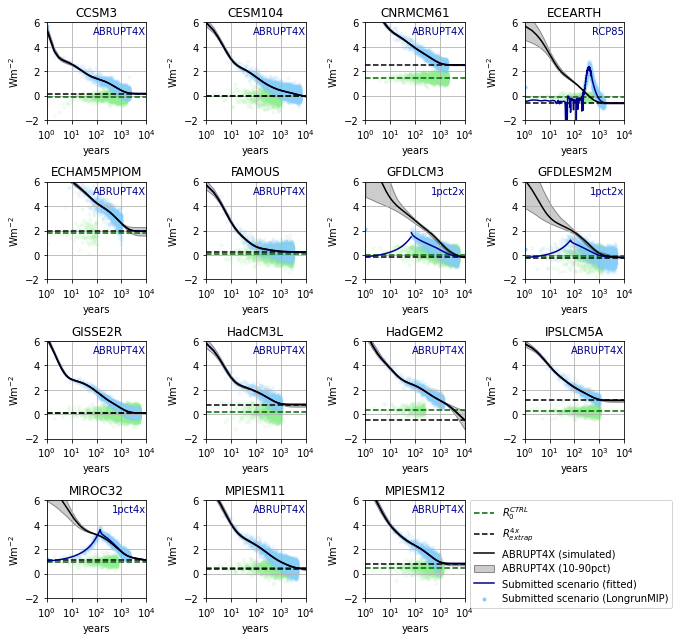

In [ ]:

fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)



for j, i in enumerate(findex[0]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='--')
  p6=axes[j].hlines(y=ti_pct[i,1,-1], xmin=1, xmax=10001, colors='black', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  axes[j].scatter(dlag[i]+x_array,y_array,color='lightskyblue',marker='.',alpha=0.1)
  p1=axes[j].scatter(x_array[0],y_array[0],color='lightskyblue',marker='.')


  axes[j].set_title(mdlslr[i])

  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),t_pct[i,0,:],t_pct[i,2,:],alpha=0.4,facecolor='grey',linestyle='-',ec='black')
  p7=axes[j].plot(dlag[i]+np.arange(1,10001),ti_pct[i,1,:],color='darkblue',linestyle='-')
  if dlag[i]>0:
    axes[j].plot(np.arange(0,dlag[i]),cnvmdlr(flt[i](np.arange(0,dlag[i])),flr[i],0,prmn[0,i],prmn[1,i],prmn[2,i],prmn[5,i],prmn[6,i],prmn[7,i],prmn[10,i]),color='darkblue',linestyle='-')
  p5=axes[j].plot(np.arange(1,10001),t_pct[i,1,:],color='black')

  axes[j].text(1e4,5,fscn[i],ha='right',color='darkblue')
  
axes[15].set_visible(False)


plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4,p7[0],p1], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (simulated)','ABRUPT4X (10-90pct)','Submitted scenario (fitted)','Submitted scenario (LongrunMIP)' ],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_lrmip.pdf", bbox_inches='tight')


###cmip5

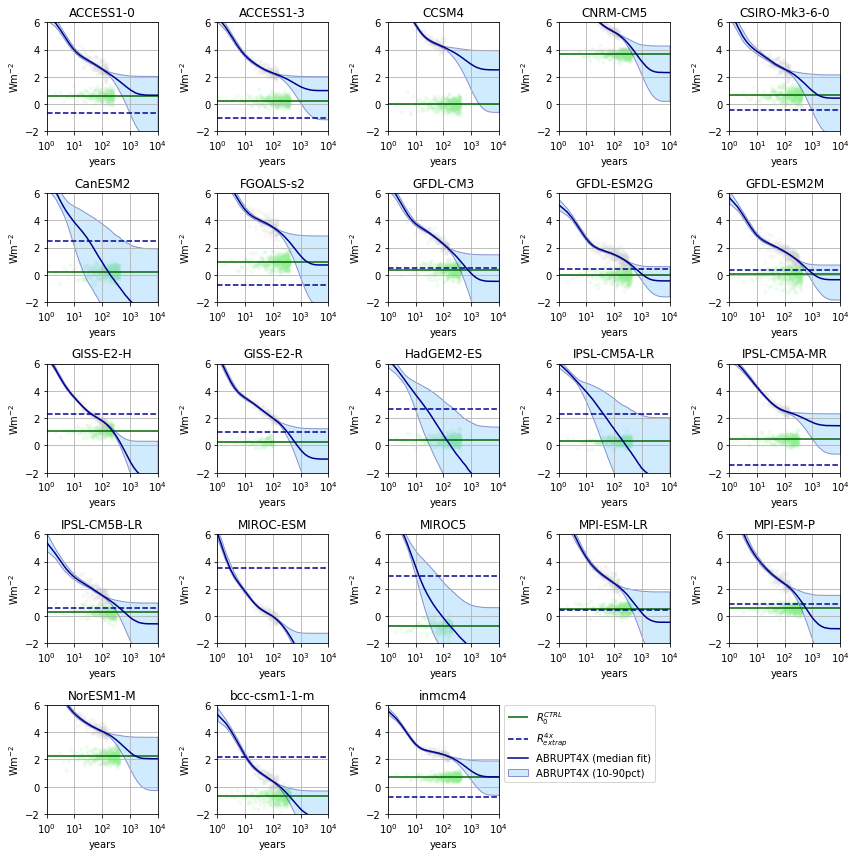

In [ ]:

fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(12)
fig.set_figwidth(12)



for j, i in enumerate(findex[1]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')
  p6=axes[j].hlines(y=-ti_pct[i,1,-1], xmin=1, xmax=10001, colors='darkblue', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),ti_pct[i,0,:],ti_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),ti_pct[i,1,:],color='darkblue')

  
axes[23].set_visible(False)
axes[24].set_visible(False)
  
plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (median fit)','ABRUPT4X (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip5.png", bbox_inches='tight')

###cmip6


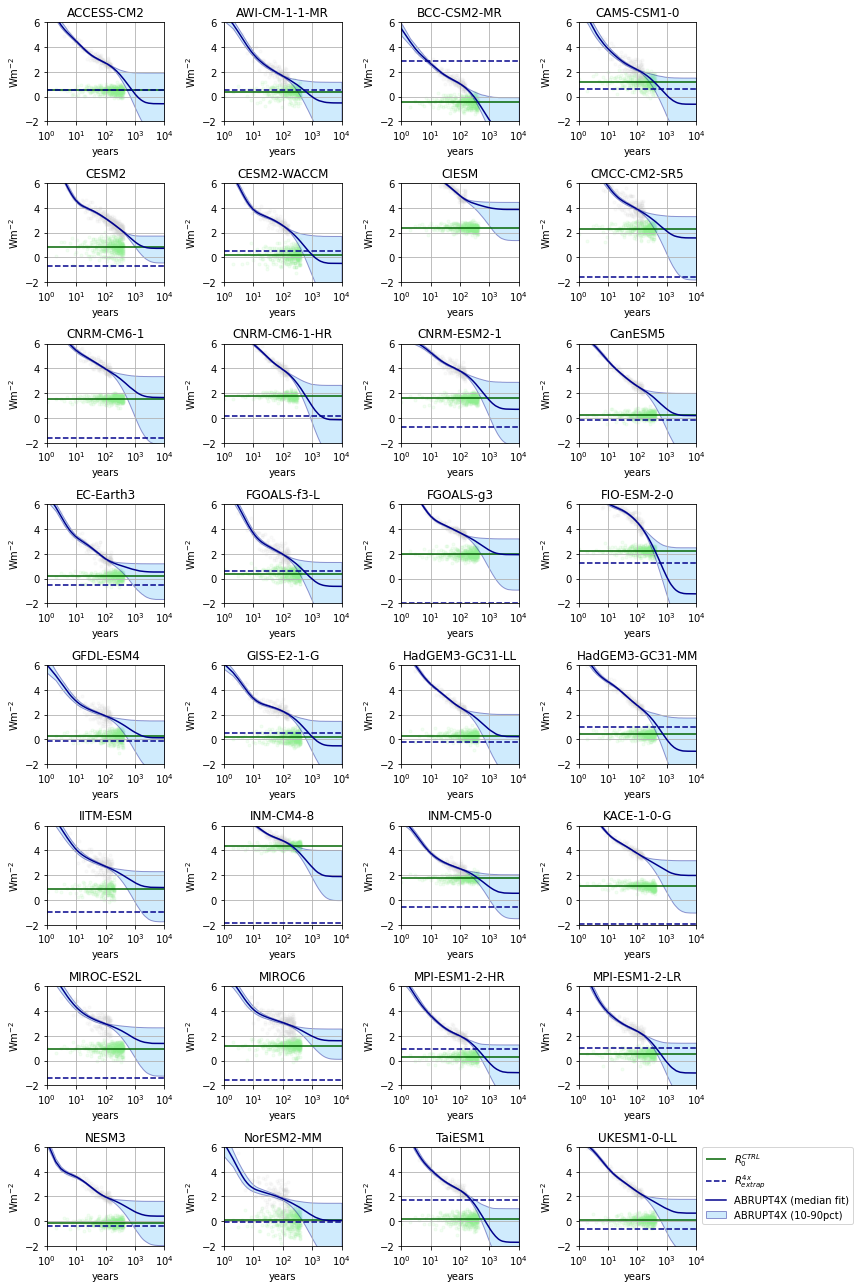

In [ ]:

fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(10)



for j, i in enumerate(findex[2]):

  p3=axes[j].hlines(y=-net_cnt_100[i], xmin=1, xmax=10001, colors='darkgreen', linestyles='-')
  p6=axes[j].hlines(y=-ti_pct[i,1,-1], xmin=1, xmax=10001, colors='darkblue', linestyles='--')

  y_array=-net_cnt[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  p0=axes[j].scatter(x_array,y_array,marker='.',color='lightgreen',alpha=.1)
  y_array=-net_4x[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p1=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,6])
  #p2=axes[j].fill_between(np.arange(1,10001),-tc_pct[i,0,:],-tc_pct[i,2,:],alpha=.4,facecolor='lightgreen',linestyle='-',ec='darkgreen')
  #p3=axes[j].plot(np.arange(1,10001),-net_cnt_100[i],color='darkgreen')

  axes[j].set_ylabel(r'Wm$^{-2}$')
  axes[j].set_xlabel('years')
  axes[j].grid()
  axes[j].set_xticks([1,10,100,1000,10000])
  p4=axes[j].fill_between(np.arange(1,10001),ti_pct[i,0,:],ti_pct[i,2,:],alpha=0.4,facecolor='lightskyblue',linestyle='-',ec='darkblue')
  p5=axes[j].plot(np.arange(1,10001),ti_pct[i,1,:],color='darkblue')

  
  
plt.tight_layout()
axes[j].legend([p3,p6,p5[0],p4], ['$R_0^{CTRL}$','$R_{extrap}^{4x}$','ABRUPT4X (median fit)','ABRUPT4X (10-90pct)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[j+1])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/extrap_cmip6.png", bbox_inches='tight')

## plot TAS


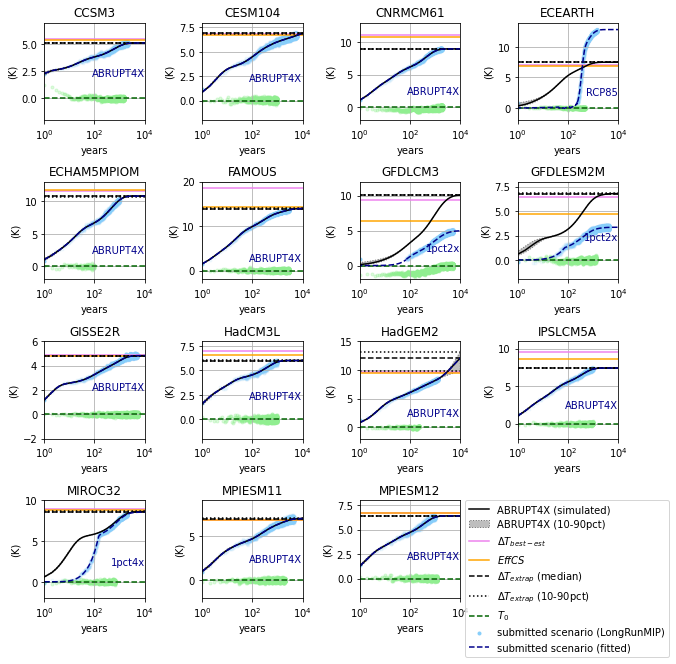

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(9)
fig.set_figwidth(9)

for j,i in enumerate(findex[0]):
  
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)

  axes[j].scatter(dlag[i]+x_array,y_array,color='lightskyblue',marker='.',alpha=0.1)
  p0=axes[j].scatter(x_array[0],y_array[0],color='lightskyblue',marker='.')

 

  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.3)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1],eti_pct[i,2,-1]])

  axes[j].set_title(mdlslr[i])


  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='grey',linestyle=':',ec='black')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  #p11=axes[j].axhline(gsensls[i],color='red')

  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='black',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='black',linestyle=':')
  p77=axes[j].axhline(et_pct[i,2,-1],color='black',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='black')
  p7=axes[j].plot(dlag[i]+np.arange(1,10001),eti_pct[i,1,:],color='darkblue',linestyle='--')
  if dlag[i]>0:
    axes[j].plot(np.arange(0,dlag[i]),cnvmdl(flt[i](np.arange(0,dlag[i])),flr[i],0,pmn[0,i],pmn[1,i],pmn[2,i],pmn[5,i],pmn[6,i],pmn[7,i]),color='darkblue',linestyle='--')
  axes[j].text(1e4,2,fscn[i],ha='right',color='darkblue')
axes[15].set_visible(False)
plt.tight_layout()
axes[j].legend([p5[0],p1,p2,p3,p4,p77,pz,p0,p7[0]], ['ABRUPT4X (simulated)','ABRUPT4X (10-90pct)','$\Delta T_{best-est}$','$EffCS$','$\Delta T_{extrap}$ (median)','$\Delta T_{extrap}$ (10-90pct)','$T_0$','submitted scenario (LongRunMIP)','submitted scenario (fitted)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_lrmip.pdf", bbox_inches='tight')



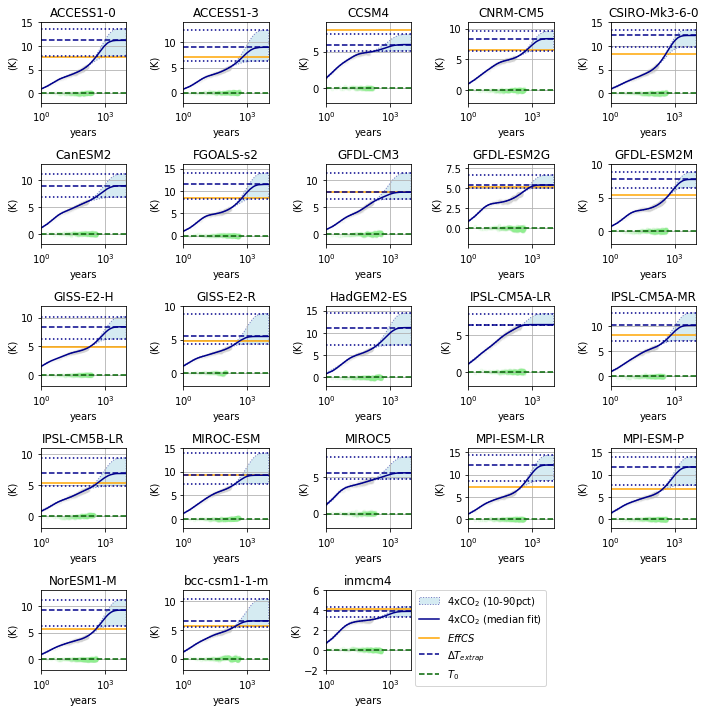

In [ ]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(10)
fig.set_figwidth(10)

for j,i in enumerate(findex[1]):
   
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1]])

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='darkblue',linestyle=':')
  axes[j].axhline(et_pct[i,2,-1],color='darkblue',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

  
plt.tight_layout()
axes[j].legend([p1,p5[0],p3,p4,pz], ['4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$EffCS$','$\Delta T_{extrap}$','$T_0$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
axes[23].axis('off')
axes[24].axis('off')
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip5.png", bbox_inches='tight', dpi=300)


In [ ]:
et_pct.shape

(75, 3, 10000)

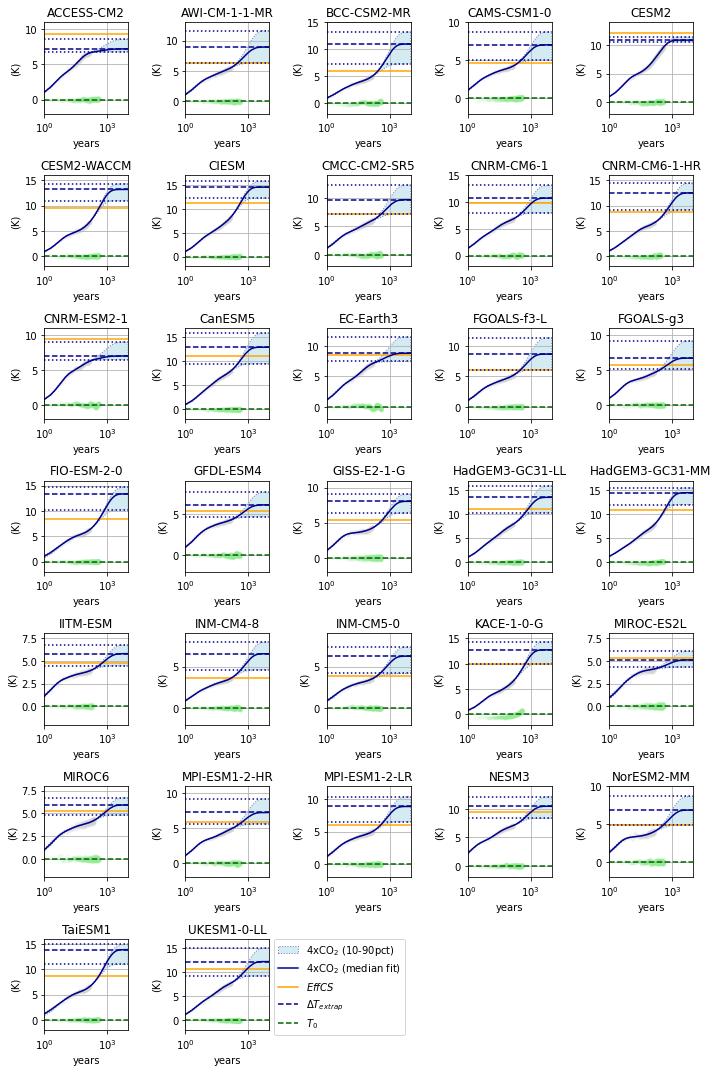

In [ ]:
fig, axes = plt.subplots(ncols=5,nrows=7)
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(10)

for j,i in enumerate(findex[2]):
   
  y_array=tsanomlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  p0=axes[j].scatter(x_array,y_array,color='lightgrey',marker='.',alpha=0.1)
  y_array=tscntlr[i,:]
  y_array = y_array[~numpy.isnan(y_array)]
  x_array=np.arange(1,len(y_array)+1)
  
  pc=axes[j].scatter(x_array,y_array,color='lightgreen',marker='.',alpha=0.1)
  pz=axes[j].axhline(0,linestyle='--',color='darkgreen')

  tmx=np.max([gsenslg[i],gsenslr[i],et_pct[i,2,-1]])

  axes[j].set_title(mdlslr[i])
  axes[j].set_xscale('log')
  axes[j].set_xlim([1,10000])
  axes[j].set_ylim([-2,np.ceil(tmx+1)])
  p1=axes[j].fill_between(np.arange(1,10001),et_pct[i,0,:],et_pct[i,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')
  p2=axes[j].axhline(gsenslg[i],color='violet')
  p3=axes[j].axhline(gsenslr[i],color='orange',linestyle='-')
  p4=axes[j].axhline(et_pct[i,1,-1],color='darkblue',linestyle='--')
  axes[j].axhline(et_pct[i,0,-1],color='darkblue',linestyle=':')
  axes[j].axhline(et_pct[i,2,-1],color='darkblue',linestyle=':')

  axes[j].grid()
  axes[j].set_ylabel(r'(K)')
  axes[j].set_xlabel('years')
  p5=axes[j].plot(np.arange(1,10001),et_pct[i,1,:],color='darkblue')

  

plt.tight_layout()
axes[j].legend([p1,p5[0],p3,p4,pz], ['4xCO$_2$ (10-90pct)','4xCO$_2$ (median fit)','$EffCS$','$\Delta T_{extrap}$','$T_0$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.delaxes(axes[32])
fig.delaxes(axes[33])
fig.delaxes(axes[34])

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/t_extrap_cmip6.png", bbox_inches='tight', dpi=300)


##plot Gregory

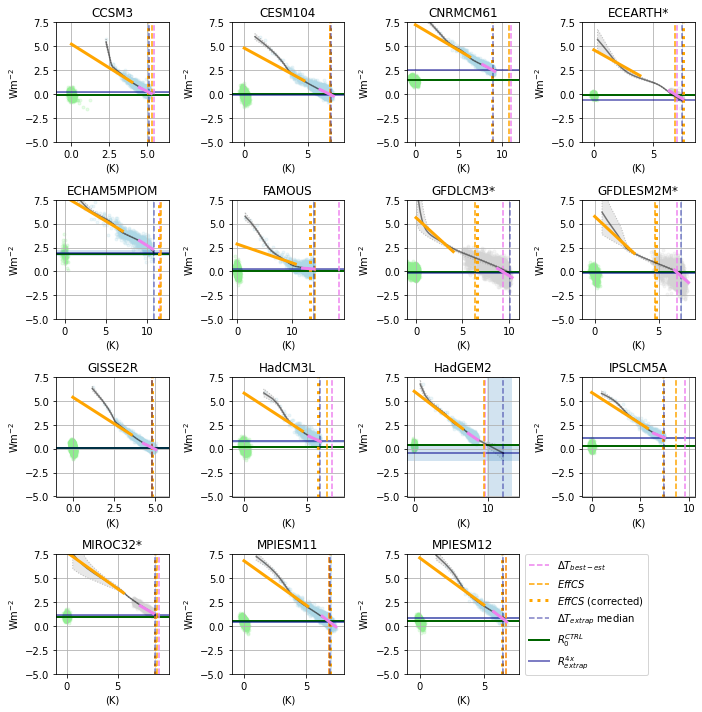

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=4)
axes = axes.flatten()

fig.set_figheight(10)
fig.set_figwidth(10)

for i, j in enumerate(findex[0]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightgrey',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  #p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')
  p22=axes[i].axvline(gsenslr_corr[j],color='orange',label='$S_{eff} (corrected)$',linestyle=':',linewidth=3)

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='--',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='black',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightgrey',linestyle=':',ec='grey')


  axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()
axes[15].set_visible(False)
axes[i].legend([p1,p2,p22,p3,p6,p7], ['$\Delta T_{best-est}$','$EffCS$','$EffCS$ (corrected)','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#fig.delaxes(axes[15])
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.png", bbox_inches='tight', dpi=600)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_lrmip.pdf", bbox_inches='tight')






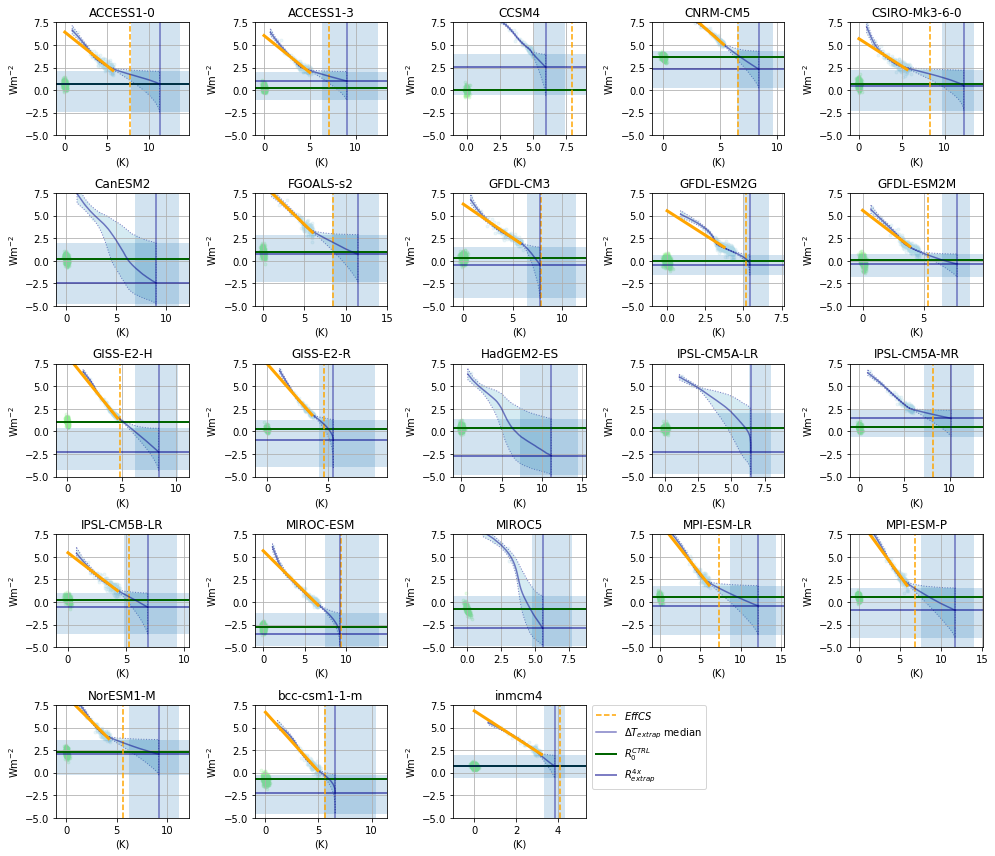

In [ ]:
fig, axes = plt.subplots(ncols=5,nrows=5)
axes = axes.flatten()

fig.set_figheight(12)
fig.set_figwidth(14)

for i, j in enumerate(findex[1]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightblue',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  #p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')


  axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')

plt.tight_layout()

axes[i].legend([p2,p3,p6,p7], ['$EffCS$','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

axes[23].axis('off')
axes[24].axis('off')

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip5.png", bbox_inches='tight', dpi=300)





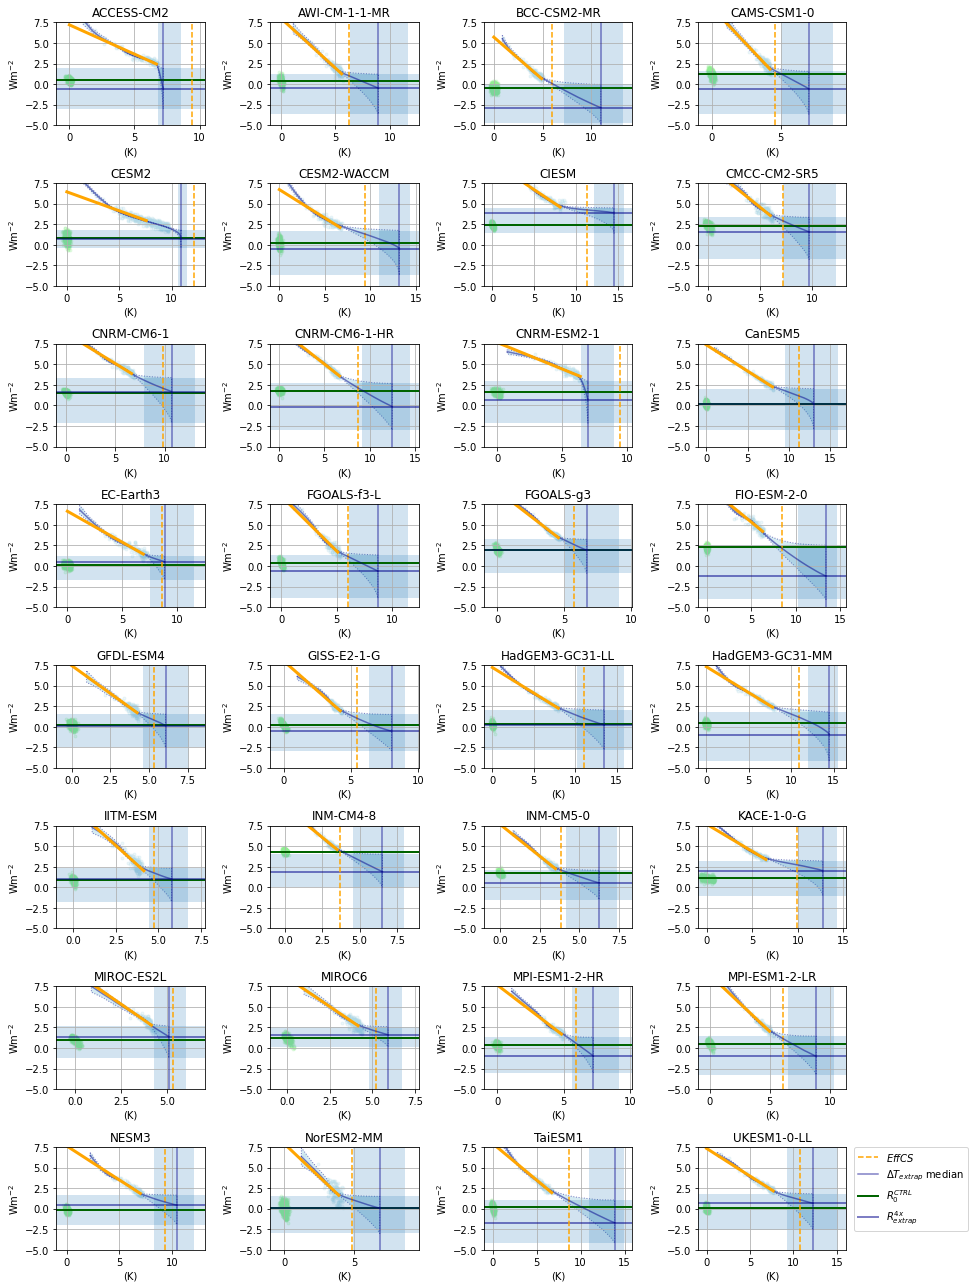

In [ ]:
fig, axes = plt.subplots(ncols=4,nrows=8)
axes = axes.flatten()

fig.set_figheight(18)
fig.set_figwidth(12)

for i, j in enumerate(findex[2]):
  if fscn[j]=='ABRUPT4X':
    p4x=axes[i].scatter(tsanomlr[j,:],-net_4x[j,:],marker='.',color='lightblue',alpha=0.2)
  else:
    p4x=axes[i].scatter(tsanomlr[j,400:]*scl[j],-net_4x[j,400:]*scl[j],marker='.',color='lightblue',alpha=0.2)

  
  pc=axes[i].scatter(tscntlr[j,:],-net_cnt[j,:],marker='.',color='lightgreen',alpha=0.2)

  if fscn[j]=='ABRUPT4X':
    axes[i].set_title(mdlslr[j])
  else:
    axes[i].set_title(mdlslr[j]+'*')

  axes[i].set_xscale('linear')

  mxv=np.max([gsenslg[j],gsenslr[j],et_pct[j,2,-1]])
  mnr=-5#np.floor(t_pct[j,0,-1])
  axes[i].set_xlim([-1,mxv+1])
  axes[i].set_ylim([mnr,7.5])

  #axes[i].axhline(0,color='k',linestyle='-')
  p6=axes[i].axhline(-net_cnt_100[j].mean(),color='darkgreen',linestyle='-',linewidth=2)
  p7=axes[i].axhline(t_pct[j,1,-1],color='darkblue',linestyle='-',linewidth=2,alpha=0.5)
  #axes[i].axhline(t_pct[j,0,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)
  #axes[i].axhline(t_pct[j,2,-1],linestyle=':',color='darkblue',label='$S_{extrap} median$',lw=1)

  rc1=Rectangle((et_pct[j,0,-1],mnr), et_pct[j,2,-1]-et_pct[j,0,-1], 8-mnr, angle=0.0,alpha=0.2)
  rc2=Rectangle((-1,t_pct[j,0,-1]), 2+mxv, t_pct[j,2,-1]-t_pct[j,0,-1], angle=0.0,alpha=0.2)

  r1=axes[i].add_patch(rc1)
  r2=axes[i].add_patch(rc2)

  #p1=axes[i].axvline(gsenslg[j],color='violet',label='$S_{LS}$',linestyle='--')
  #p11=axes[i].axvline(gsensls[j],color='red',label='$S_{LR}$',linestyle='--')

  p2=axes[i].axvline(gsenslr[j],color='orange',label='$S_{eff}$',linestyle='--')

  p3=axes[i].axvline(et_pct[j,1,-1],linestyle='-',color='darkblue',alpha=0.5)
  #axes[i].axvline(et_pct[j,0,-1],linestyle=':',color='darkblue',lw=1)
  #axes[i].axvline(et_pct[j,2,-1],linestyle=':',color='darkblue',lw=1)
  

  axes[i].plot(et_pct[j,1,:],t_pct[j,1,:],color='darkblue',linestyle='-',alpha=.5)
  axes[i].fill_between(et_pct[j,1,:],t_pct[j,0,:],t_pct[j,2,:],alpha=.5,facecolor='lightblue',linestyle=':',ec='darkblue')


  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcglg[j]/gsenslg[j],gfcglg[j]-net_cnt_100[j]),'violet',linewidth=3,linestyle='-')
  #axes[i].plot([tmax[j]*0.85,tmax[j]],linear([tmax[j]*0.85,tmax[j]],-gfcgls[j]/gsensls[j],gfcgls[j]-net_cnt_100[j]),'red',linewidth=3,linestyle='-')

  axes[i].plot([0.,t150[j,0]],linear([0.,t150[j,0]],-gfcglr[j]/gsenslr[j],gfcglr[j]-net_cnt_100[j]),'orange',linewidth=3,linestyle='-')
  #axes[i].text(-1,7,'$n_{yr}$='+str(lents[j]))
  ex=(et_pct[j,2,-1]+et_pct[j,0,-1])/2
  ey=(t_pct[j,2,-1]+t_pct[j,0,-1])/2
  #ellipse = Ellipse(xy=(ex,ey), width=et_pct[j,2,-1]-et_pct[j,0,-1], height=t_pct[j,2,-1]-t_pct[j,0,-1], 
  #                      edgecolor='darkblue', fc='lightblue', lw=2,linestyle='-')
  
  #p4=axes[i].add_patch(ellipse)
  axes[i].grid('on')
  axes[i].set_ylabel(r'Wm$^{-2}$')
  axes[i].set_xlabel(r'(K)')


plt.tight_layout()

axes[i].legend([p2,p3,p6,p7], ['$EffCS$','$\Delta T_{extrap}$ median','$R_0^{CTRL}$','$R_{extrap}^{4x}$'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/greg_cmip6.png", bbox_inches='tight', dpi=300)





##plot summary plots


In [ ]:
gsenslr_corr[13]

array([8.61375161])

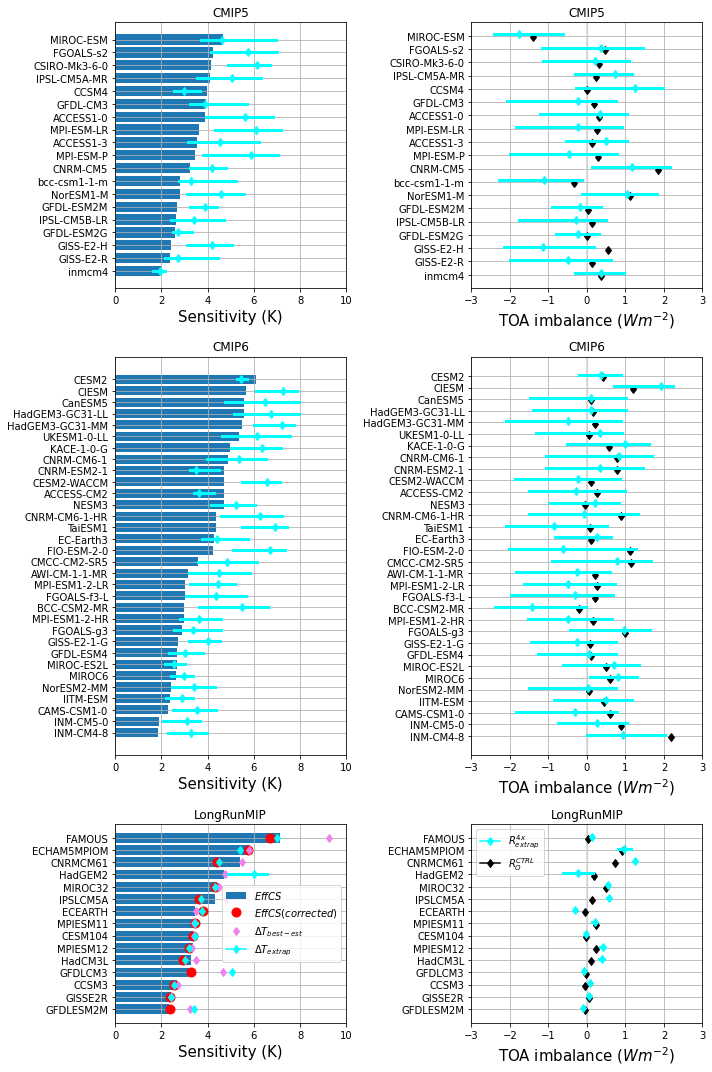

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=3, gridspec_kw={'height_ratios': [2,3,1.5]})
axes = axes.flatten()

fig.set_figheight(15)
fig.set_figwidth(10)
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensCorr":[gsenslr_corr[ii,0]/2 for ii in indy],
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "SensLS":[gsensls[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii]/2 for ii in indy],
                    #"Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    #"Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    #"Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy]
                     })
  df_sorted= df.sort_values('Sens')
  df_sorted=df_sorted.dropna(subset=['Sens'])
  # bar plot with matplotlib

  plt1=axes[2*i-2].barh('Model', 'Sens',data=df_sorted)
  yp=axes[2*i-2].get_yticks()
  axes[2*i-2].set_xlabel("Sensitivity (K)", size=15)
  axes[2*i-2].set_xlim([0,10])
  if i==0:
 #   pr=axes[2*i-2].plot(df_sorted.SensLS.to_numpy(),yp,'d',color='r')
     pr=axes[2*i-2].plot(df_sorted.SensCorr.to_numpy(),yp,'o',color='r',markersize=9) 
  
  pv=axes[2*i-2].plot(df_sorted.SensLG.to_numpy(),yp,'d',color='violet')
  axes[2*i-2].set_title(gens[i])
  for j,jj in enumerate(df_sorted.index):
    axes[2*i-2].plot([df_sorted.Sens10.to_numpy()[j],df_sorted.Sens90.to_numpy()[j]],[yp[j],yp[j]],'cyan',linewidth=3)
    pc=axes[2*i-2].plot([df_sorted.Sens50.to_numpy()[j]],yp[j],'-',color='cyan',markerfacecolor='cyan',markeredgecolor='cyan',marker='d')
 
  axes[2*i-2].grid()
  if i==2:
    axes[2*i].legend([plt1,pr[0],pv[0],pc[0]],['$EffCS$','$EffCS (corrected)$','$\Delta T_{best-est}$','$\Delta T_{extrap}$'])
  

  plt1=axes[2*i-1].barh('Model', 'zetaLG',data=df_sorted,ec='none',fc='none')
  yp=axes[2*i-1].get_yticks()
  axes[2*i-1].set_xlabel("TOA imbalance $(Wm^{-2})$", size=15)
  axes[2*i-1].set_xlim([-3,3])
  axes[2*i-1].set_title(gens[i])
  axes[2*i-1].grid()

  axes[2*i-1].axvline(0, color='lightgrey',linestyle='-')
  for j,jj in enumerate(df_sorted.index):
    #axes[3*i-1].plot([df_sorted.cbal10.to_numpy()[j],df_sorted.cbal90.to_numpy()[j]],[yp[j]-.1,yp[j]-.1],'black')
    pb=axes[2*i-1].plot([df_sorted.cbal50.to_numpy()[j]],yp[j]-.1,'black',marker='d')
    axes[2*i-1].plot([df_sorted.cbal410.to_numpy()[j],df_sorted.cbal490.to_numpy()[j]],[yp[j]+0.1,yp[j]+0.1],'cyan',linewidth=3)
    axes[2*i-1].plot([df_sorted.cbal450.to_numpy()[j]],yp[j]+0.1,'cyan',marker='d')

  if i==2:
    axes[2*i+1].legend([pc[0],pb[0]],['$R_{extrap}^{4x}$','$R_O^{CTRL}$'])
  


fig.tight_layout()
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/histo.pdf", bbox_inches='tight')



In [ ]:
df_sorted

,Model,Sens,SensCorr,SensLG,SensLS,Sens10,Sens50,Sens90,zetaLG,zeta10,zeta50,zeta90,cbal410,cbal450,cbal490,cbal50


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('ECSTCR').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()


# Convert to a DataFrame and render.
import pandas as pd
df=pd.DataFrame.from_records(rows)
df=df.rename(columns=df.iloc[0]).drop(df.index[0])
df=df.set_index('Model')
df
snsmhl=np.nan*np.zeros(len(mdlslr))
tcrmhl=np.nan*np.zeros(len(mdlslr))

for i,mdl in enumerate(mdlslr):
  if mdl in df.index:
    if len(df.loc[mdl].ECS)>0:
      snsmhl[i]=df.loc[mdl].ECS
    else:
      snsmhl[i]-np.nan
    if len(df.loc[mdl].TCR)>0:
      tcrmhl[i]=df.loc[mdl].TCR
    else:
      tcrmhl[i]-np.nan
  else:
    snsmhl[i]=np.nan
    tcrmhl[i]=np.nan

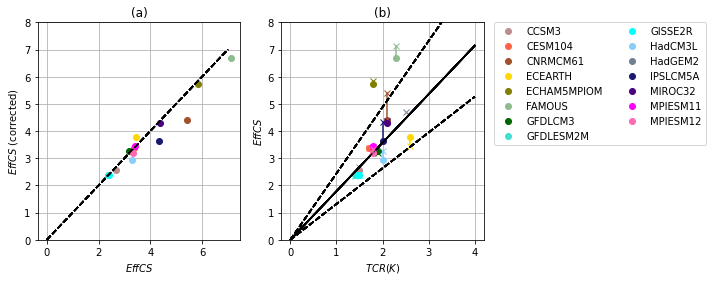

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(8, 4))
markercycle = cycler(marker=['o', '+', 'x', '*', '.', 'X'])
clr=['rosybrown','tomato','sienna','gold','olive','darkseagreen','darkgreen','turquoise','cyan','lightskyblue','slategrey','midnightblue','indigo','fuchsia','hotpink','crimson']
colorcycle = cycler(color=clr)


axes = axes.flatten()
p1=[]


axes[0].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis
axes[1].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis
#axes[2].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis
#axes[3].set_prop_cycle(markercycle * colorcycle ) # gca()=current axis
#fig.delaxes(axes[1])
#axes[0].hist(gsenslr_corr[0:15,0]/tcrmhl[0:15]/2,color='k')
#axes[0].hist(gsenslr[0:15,0]/tcrmhl[0:15]/2,color='r')

for i,us in enumerate(findex[0]):
  p1.append(axes[0].plot(gsenslr[us]/2,gsenslr_corr[us]/2,'o',label=mdlslr[us])[0])
  axes[0].plot([0,7],[0,7],'k--')
  axes[0].set_xlabel('$EffCS$')
  axes[0].set_ylabel('$EffCS$ (corrected)')


  axes[1].plot(tcrmhl[us],gsenslr_corr[us]/2,'o',label=mdlslr[us],fillstyle='full',color=clr[i])
  axes[1].plot([0,4],[0,4/0.41],'k--')
  axes[1].plot([0,4],[0,4/0.76],'k--')
  axes[1].plot([0,4],[0,4/0.56],'k-')
  axes[1].plot(tcrmhl[us],gsenslr[us]/2,'x',label=mdlslr[us],fillstyle='none',color=clr[i])
  axes[1].plot(tcrmhl[us]*np.array([1,1]),np.array([gsenslr[us],gsenslr_corr[us]])/2,'-',color=clr[i])

  axes[1].set_xlabel('$TCR (K)$')
  axes[1].set_ylabel('$EffCS$')
  axes[1].set_ylim([0,8])
  axes[1].grid()
  axes[0].set_title('(a)')
  axes[1].set_title('(b)')

  axes[0].grid()
  axes[0].set_ylim([0,8])

  #axes[3].plot([0,4],[0,4/0.41],'k--')
  #axes[3].plot([0,4],[0,4/0.76],'k--')
  #axes[3].plot([0,4],[0,4/0.56],'k-')

axes[1].legend(handles=p1, ncol=2,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/ecstcr.png", bbox_inches='tight', dpi=300)
plt.savefig("/content/drive/MyDrive/colab_4xco2/figures/ecstcr.pdf", bbox_inches='tight')



#make tables

In [ ]:
for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens":[gsenslr[ii,0]/2 for ii in indy],
                    "SensCorr":[gsenslr_corr[ii,0]/2 for ii in indy],
                    "Corr":[gsenslr_corr[ii,0]/2-gsenslr[ii,0]/2 for ii in indy],
                     
                    "SensLG":[gsenslg[ii,0]/2 for ii in indy],
                    "SensLS":[gsensls[ii,0]/2 for ii in indy],
                    "Sens10":[et_pct[ii,0,-1]/2 for ii in indy],
                    "Sens50":[et_pct[ii,1,-1]/2 for ii in indy],
                    "Sens90":[et_pct[ii,2,-1]/2 for ii in indy],
                    "zetaLG":[gsenslg[ii,0]/gsenslr[ii,0] for ii in indy],
                    "zeta10":[et_pct[ii,0,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta50":[et_pct[ii,1,-1]/gsenslr[ii,0] for ii in indy],
                    "zeta90":[et_pct[ii,2,-1]/gsenslr[ii,0] for ii in indy],
                    "cbal410":[t_pct[ii,0,-1]/2 for ii in indy],
                    "cbal450":[t_pct[ii,1,-1]/2 for ii in indy],
                    "cbal490":[t_pct[ii,2,-1]/2 for ii in indy],
                    "cbal50":[-net_cnt_100[ii,0]/2 for ii in indy],
                    #"Sensc10":[etc_pct[ii,0,-1]/2 for ii in indy],
                    #"Sensc50":[etc_pct[ii,1,-1]/2 for ii in indy],
                    #"Sensc90":[etc_pct[ii,2,-1]/2 for ii in indy],
                    "len4x":[len4x[ii,0].astype(int).astype(str) for ii in indy],})
  df['srng']=df.Sens50.round(2).astype(str).str.cat(df['Sens10'].round(2).astype(str).str.cat(df['Sens90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['zrng']=df.zeta50.round(2).astype(str).str.cat(df['zeta10'].round(2).astype(str).str.cat(df['zeta90'].round(2).astype(str),sep=','),sep=' (')+')'
  df['cbrng']=df.cbal450.round(2).astype(str).str.cat(df['cbal410'].round(2).astype(str).str.cat(df['cbal490'].round(2).astype(str),sep=','),sep=' (')+')'
  #df['s150rng']=df.Sensc50.round(2).astype(str).str.cat(df['Sensc10'].round(2).astype(str).str.cat(df['Sensc90'].round(2).astype(str),sep=','),sep=' (')+')'
  if i==0:
     df2=df[['Model','len4x','Sens','SensCorr','Corr','SensLG','srng','cbrng','cbal50']].rename(columns={'Sens': '$EffCS$','SensCorr': '$EffCS_{corr}$',
     'Corr':'Difference', 'SensLG': '$\Delta T_{best-est}$', 'len4x': 'Years','srng': '$\Delta T_{extrap}$','cbrng':'$R^{4x}_{extrap}$','cbal50':'$R^{CTRL}_0$'})
  else:
     df2=df[['Model','len4x','Sens','SensLG','srng','cbrng','cbal50']].rename(columns={'Sens': '$EffCS$', 'SensLG': '$\Delta T_{best-est}$', 'len4x': 'Years','srng': '$\Delta T_{extrap}$','cbrng':'$R^{4x}_{extrap}$','cbal50':'$R^{CTRL}_0$'})

  df2=df2.round(2)
  print(df2.to_latex(index=False, escape=False, na_rep='-'))


\begin{tabular}{llrrrrllr}
\toprule
      Model & Years &  $EffCS$ &  $EffCS_{corr}$ &  Difference &  $\Delta T_{best-est}$ & $\Delta T_{extrap}$ &   $R^{4x}_{extrap}$ &  $R^{CTRL}_0$ \\
\midrule
      CCSM3 &  2120 &     2.68 &            2.55 &       -0.13 &                   2.73 &    2.56 (2.55,2.56) &     0.09 (0.07,0.1) &         -0.04 \\
    CESM104 &  5900 &     3.37 &            3.38 &        0.01 &                   3.39 &    3.44 (3.43,3.45) & -0.03 (-0.04,-0.01) &         -0.02 \\
   CNRMCM61 &  1850 &     5.42 &            4.42 &       -0.99 &                   5.51 &    4.47 (4.47,4.48) &    1.26 (1.25,1.27) &          0.73 \\
    ECEARTH &  1271 &     3.44 &            3.79 &        0.35 &                   3.50 &    3.75 (3.74,3.76) &  -0.3 (-0.32,-0.28) &         -0.06 \\
ECHAM5MPIOM &  1001 &     5.84 &            5.73 &       -0.10 &                   5.81 &     5.4 (5.37,5.45) &    0.97 (0.79,1.14) &          0.92 \\
     FAMOUS &  3000 &     7.13 &            6.68 

(x, i, s1, s2, s3, s4,s5, t1, t2, t3,t4,t5,c):

In [ ]:
prmn_prc.shape

(11, 75, 3)

In [ ]:
ii=1
f'{pmn_prc[0,ii,1]:.3}'+' ('+f'{pmn_prc[0,ii,0]:.3}'+','+f'{pmn_prc[0,ii,2]:.3}'+')'

'2.49 (2.42,2.55)'

In [ ]:

for i,indy in enumerate(findex):

  df = pd.DataFrame({"Model":[mdlslr[ii] for ii in indy],
                    "Sens1":[f'{pmn_prc[0,ii,1]:.1f}'.replace('nan', '-')+'('+f'{pmn_prc[0,ii,0]:.1f}'.replace('nan', '-')+','+f'{pmn_prc[0,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Sens2":[f'{pmn_prc[1,ii,1]:.1f}'.replace('nan', '-')+'('+f'{pmn_prc[1,ii,0]:.1f}'.replace('nan', '-')+','+f'{pmn_prc[1,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Sens3":[f'{pmn_prc[2,ii,1]:.1f}'.replace('nan', '-')+'('+f'{pmn_prc[2,ii,0]:.1f}'.replace('nan', '-')+','+f'{pmn_prc[2,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Sens4":[f'{pmn_prc[3,ii,1]:.1f}'.replace('nan', '-')+'('+f'{pmn_prc[3,ii,0]:.1f}'.replace('nan', '-')+','+f'{pmn_prc[3,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Sens5":[f'{pmn_prc[4,ii,1]:.1f}'.replace('nan', '-')+'('+f'{pmn_prc[4,ii,0]:.1f}'.replace('nan', '-')+','+f'{pmn_prc[4,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Rad1":[f'{prmn_prc[0,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[0,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[0,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Rad2":[f'{prmn_prc[1,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[1,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[1,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Rad3":[f'{prmn_prc[2,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[2,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[2,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Rad4":[f'{prmn_prc[3,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[3,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[3,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Rad5":[f'{prmn_prc[4,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[4,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[4,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Tau1":[f'{prmn_prc[5,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[5,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[5,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Tau2":[f'{prmn_prc[6,ii,1]:.1f}'.replace('nan', '-')+'('+f'{prmn_prc[6,ii,0]:.1f}'.replace('nan', '-')+','+f'{prmn_prc[6,ii,2]:.1f}'.replace('nan', '-')+')' for ii in indy],
                    "Tau3":[f'{prmn_prc[7,ii,1]:.0f}'.replace('nan', '-')+'('+f'{prmn_prc[7,ii,0]:.0f}'.replace('nan', '-')+','+f'{prmn_prc[7,ii,2]:.0f}'.replace('nan', '-')+')' for ii in indy],
                    "Tau4":[f'{prmn_prc[8,ii,1]:.0f}'.replace('nan', '-')+'('+f'{prmn_prc[8,ii,0]:.0f}'.replace('nan', '-')+','+f'{prmn_prc[8,ii,2]:.0f}'.replace('nan', '-')+')' for ii in indy],
                    "Tau5":[f'{prmn_prc[9,ii,1]:.0f}'.replace('nan', '-')+'('+f'{prmn_prc[9,ii,0]:.0f}'.replace('nan', '-')+','+f'{prmn_prc[9,ii,2]:.0f}'.replace('nan', '-')+')' for ii in indy],
                    "Rext":[f'{prmn_prc[10,ii,1]:.2}'.replace('nan', '-')+'('+f'{prmn_prc[10,ii,0]:.2}'.replace('nan', '-')+','+f'{prmn_prc[10,ii,2]:.2}'.replace('nan', '-')+')' for ii in indy],})
  df2=df[['Model','Sens1','Sens2','Sens3','Sens4','Sens5','Rad1','Rad2','Rad3','Rad4','Rad5','Tau1','Tau2','Tau3','Tau4','Tau5','Rext']].rename(columns={'Sens1': '$S_1$','Sens2': '$S_2$','Sens3': '$S_3$','Sens4': '$S_4$','Sens5': '$S_5$','Rad1': '$R_1$','Rad2': '$R_2$','Rad3': '$R_3$','Rad4': '$R_4$','Rad5': '$R_5$','Tau1': '$\tau_1$','Tau2': '$\tau_2$','Tau3': '$\tau_3$','Tau4': '$\tau_4$','Tau5': '$\tau_5$', 'Rext': '$R^{4x}_{extrap}$'})

  df2=df2.applymap(lambda x:  round(x, 2 - int(np.floor(np.log10(abs(x))))) if ((isinstance(x, float) and ~np.isnan(x))) else x)
  df2=df2.round(2)
  print(df2.to_latex(index=False, escape=False, na_rep='-'))

\begin{tabular}{lllllllllllllllll}
\toprule
      Model &        $S_1$ &        $S_2$ &        $S_3$ &        $S_4$ &        $S_5$ &        $R_1$ &        $R_2$ &        $R_3$ &        $R_4$ &        $R_5$ &     $\tau_1$ &        $\tau_2$ &     $\tau_3$ &        $\tau_4$ &        $\tau_5$ &   $R^{4x}_{extrap}$ \\
\midrule
      CCSM3 & 2.5(2.4,2.6) & 1.1(1.0,1.2) & 1.5(1.5,1.5) &       -(-,-) &       -(-,-) & 9.0(7.2,9.8) & 1.5(1.4,1.7) & 1.5(1.4,1.5) &       -(-,-) &       -(-,-) & 0.8(0.7,0.9) & 22.2(19.0,26.1) & 581(549,615) &          -(-,-) &          -(-,-) &     0.17(0.15,0.19) \\
    CESM104 & 3.2(3.1,3.2) & 1.6(1.5,1.6) & 1.2(1.1,1.2) & 1.1(1.1,1.1) &       -(-,-) & 4.1(3.7,4.5) & 1.2(1.0,1.4) & 1.0(0.8,1.2) & 0.6(0.6,0.7) &       -(-,-) & 4.8(4.0,5.6) & 78.1(56.7,94.9) & 326(260,403) & 4092(3138,4824) &          -(-,-) & -0.11(-0.16,-0.049) \\
   CNRMCM61 & 2.7(2.6,2.9) & 2.7(2.6,2.9) & 3.5(3.5,3.5) &       -(-,-) &       -(-,-) & 3.5(3.0,4.0) & 1.4(1.2,1.6) & 1.6(1.5,1.7) & 